### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/test_run_no_risk_effect_no_treatment/alabama/2023_06_23_09_20_25/count_data

deaths.csv              risk_exposure_time.hdf  transition_count.csv  ylds.hdf
deaths.hdf              state_person_time.csv   transition_count.hdf  ylls.csv
risk_exposure_time.csv  state_person_time.hdf   ylds.csv              ylls.hdf


In [2]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/test_run_no_risk_effect_no_treatment/alabama/2023_06_23_09_20_25/count_data'

## Checking Stability of Risks over Time

In [7]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.loc[person_time.scenario == 'baseline']
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

age     sex  year  input_draw       ptvalue
0  25_to_29  female  2021          29  29561.330595
1  25_to_29  female  2021         232  29334.800821
2  25_to_29  female  2021         357  29488.350445
3  25_to_29  female  2021         394  29370.370979
4  25_to_29  female  2021         602  29265.423682

In [5]:
%%capture
for sex in per_time_group.sex.unique():
    for age in per_time_group.age.unique():
        plt.figure() 
        subdata = per_time_group.loc[(per_time_group.sex==sex) & (per_time_group.age==age)]
        plt.plot(subdata['year'], subdata['ptvalue'], marker='o')
        #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Person Time: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,300000)
        plt.grid()

### BMI

In [4]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  female  2021  high_body_mass_index_in_adults   
1           1  female  2021  high_body_mass_index_in_adults   
2           2  female  2021  high_body_mass_index_in_adults   
3           3  female  2021  high_body_mass_index_in_adults   
4           4  female  2021  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age          value  
0  risk_exposure_time          29       baseline  25_to_29  915364.430528  
1  risk_exposure_time          29  lifestyle_100  25_to_29  915364.430528  
2  risk_exposure_time          29   lifestyle_50  25_to_29  915364.430528  
3  risk_exposure_time          29   outreach_100  25_to_29  915364.430528  
4  risk_exposure_time          29    outreach_50  25_to_29  915364.430528

In [5]:
bmi_exp = risk_exp.loc[(risk_exp['risk']=='high_body_mass_index_in_adults') & (risk_exp['scenario']=='baseline')]
bmi_exp.head()

Unnamed: 0     sex  year                            risk  \
0            0  female  2021  high_body_mass_index_in_adults   
7            7  female  2021  high_body_mass_index_in_adults   
14          14  female  2021  high_body_mass_index_in_adults   
21          21  female  2021  high_body_mass_index_in_adults   
28          28  female  2021  high_body_mass_index_in_adults   

               measure  input_draw  scenario       age          value  
0   risk_exposure_time          29  baseline  25_to_29  915364.430528  
7   risk_exposure_time          29  baseline  30_to_34  891281.388227  
14  risk_exposure_time          29  baseline  35_to_39  869104.727147  
21  risk_exposure_time          29  baseline  40_to_44  835505.160003  
28  risk_exposure_time          29  baseline  45_to_49  883424.515011

In [8]:
bmi_exp_summ = (bmi_exp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_exp_summ.head()

age     sex  year           mean           2.5%          97.5%
0  25_to_29  female  2021  900888.110767  892418.159282  915364.430528
1  25_to_29  female  2022  832356.444448  824179.821963  845928.916765
2  25_to_29  female  2023  825757.739052  816304.943434  835867.192774
3  25_to_29  female  2024  817048.386596  805367.056304  825524.788287
4  25_to_29  female  2025  810311.825851  796930.057882  817685.913790

In [9]:
%%capture
for sex in bmi_exp_summ.sex.unique():
    for age in bmi_exp_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_summ.loc[(bmi_exp_summ.sex==sex) & (bmi_exp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [8]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']
#bmi_exp_rate_summ = (bmi_exp_rate
#                .groupby(['age', 'sex', 'year','input_draw'])
#                .bmi_rate.describe(percentiles=[.025,0.5, .975])
#                .filter(['mean', '50%','2.5%', '97.5%'])
#                .reset_index())
bmi_exp_rate.head()

age     sex  year  input_draw          value       ptvalue   bmi_rate
0  25_to_29  female  2021          29  915364.430528  29561.330595  30.964927
1  25_to_29  female  2021         232  893341.506881  29334.800821  30.453301
2  25_to_29  female  2021         357  900858.213798  29488.350445  30.549631
3  25_to_29  female  2021         394  901430.167109  29370.370979  30.691821
4  25_to_29  female  2021         602  899151.714518  29265.423682  30.724029

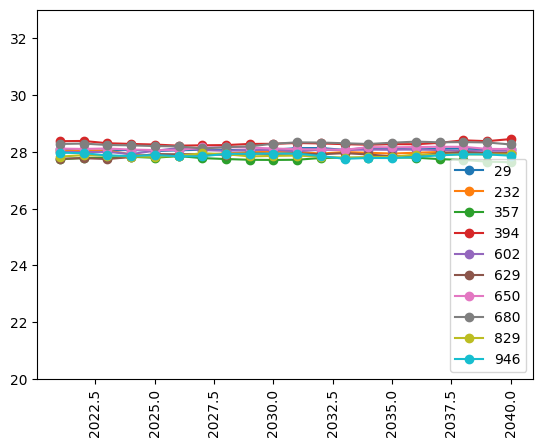

In [11]:
for draw in bmi_exp_rate_summ.input_draw.unique():
    #plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex=='female') & (bmi_exp_rate_summ.age=='85_to_89') & (bmi_exp_rate_summ.input_draw==draw)]
    plt.plot(subdata['year'], subdata['mean'], marker='o', label=draw)
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    #plt.title(f'BMI Exposure: {sex} in {age}') 
    plt.xticks(rotation=90) 
    plt.ylim(20,33)
    plt.grid()
    plt.legend()

In [9]:
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

age     sex  year       mean        50%       2.5%      97.5%
0  25_to_29  female  2021  30.740249  30.707925  30.474975  31.036567
1  25_to_29  female  2022  30.732840  30.710330  30.432016  31.036896
2  25_to_29  female  2023  30.732336  30.741033  30.409935  31.023320
3  25_to_29  female  2024  30.738005  30.711664  30.426648  31.003596
4  25_to_29  female  2025  30.745946  30.726269  30.431445  30.985244

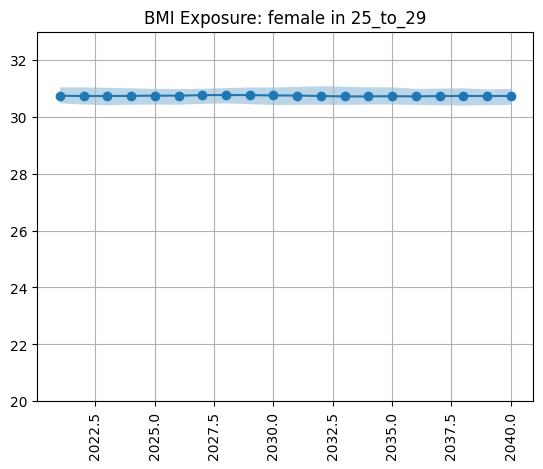

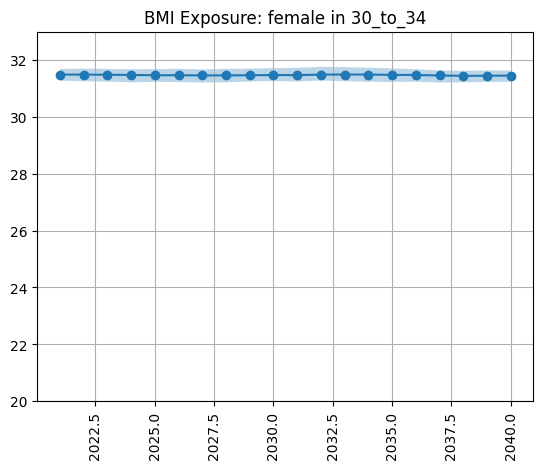

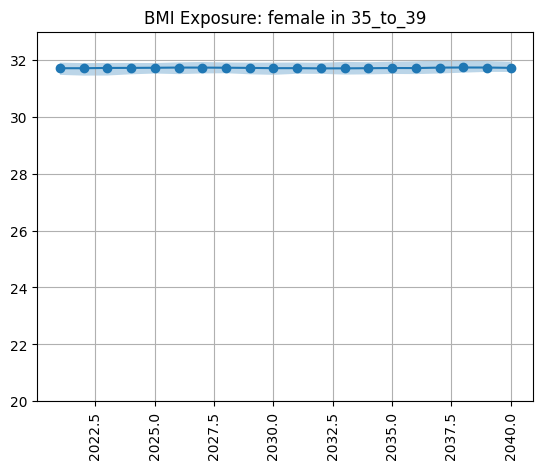

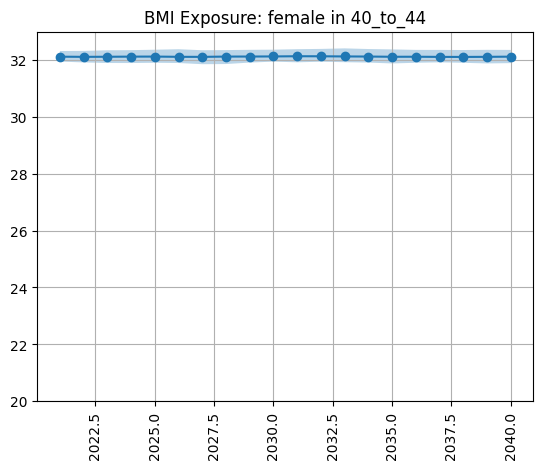

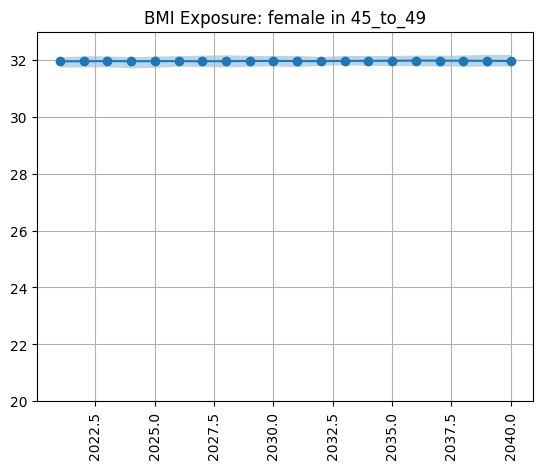

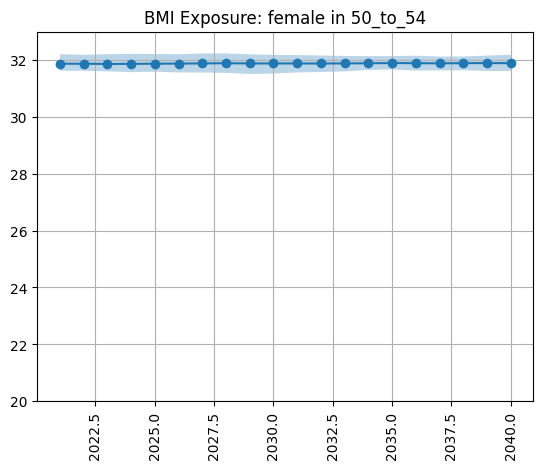

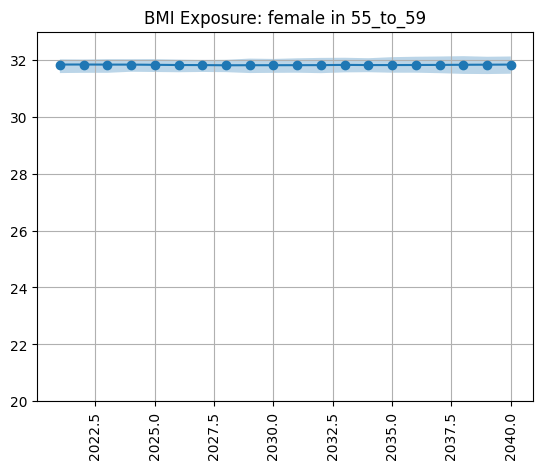

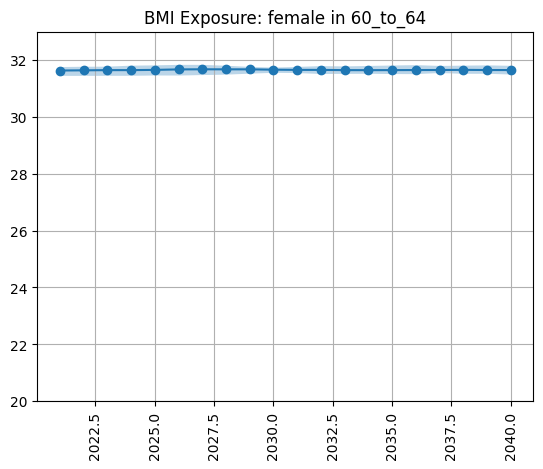

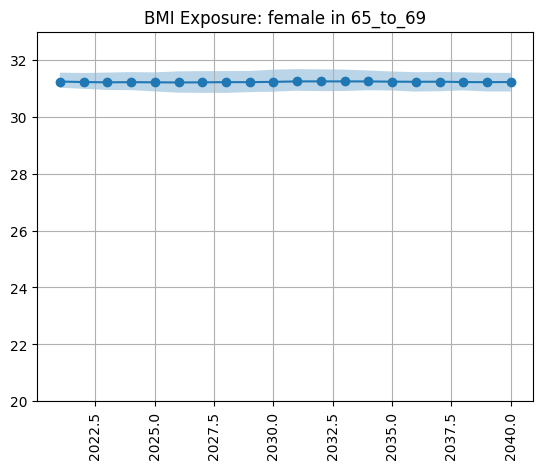

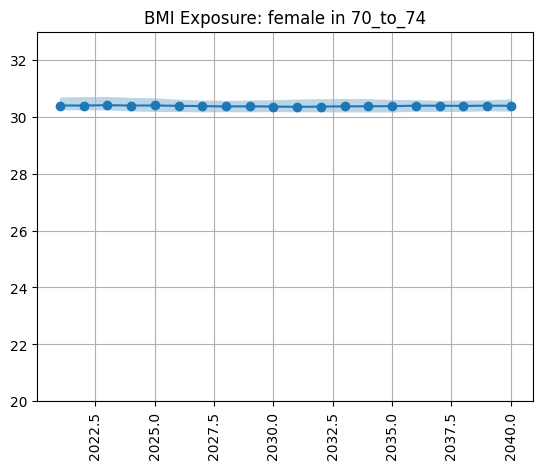

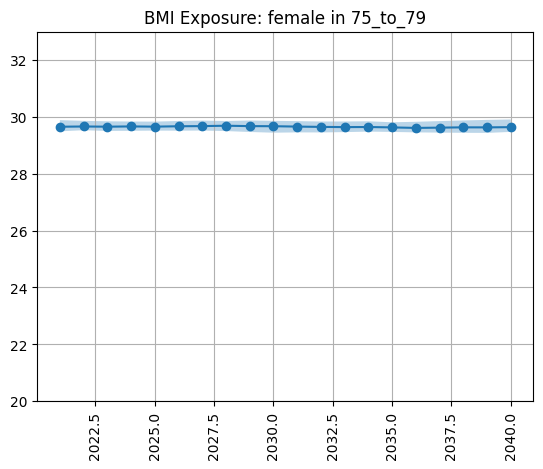

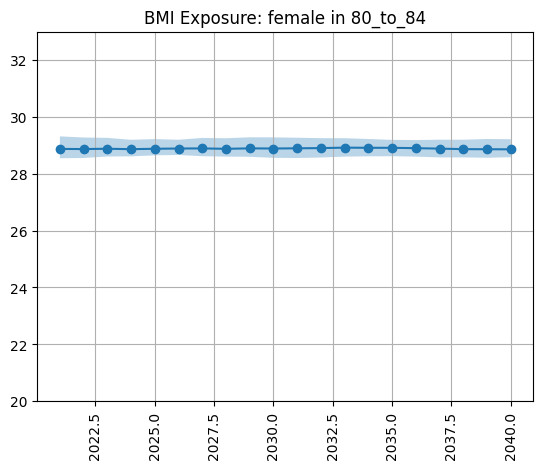

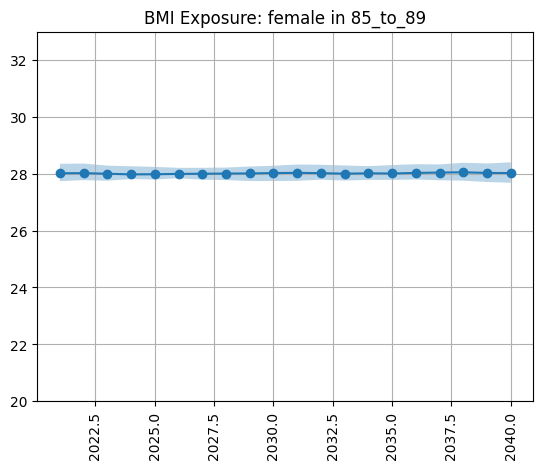

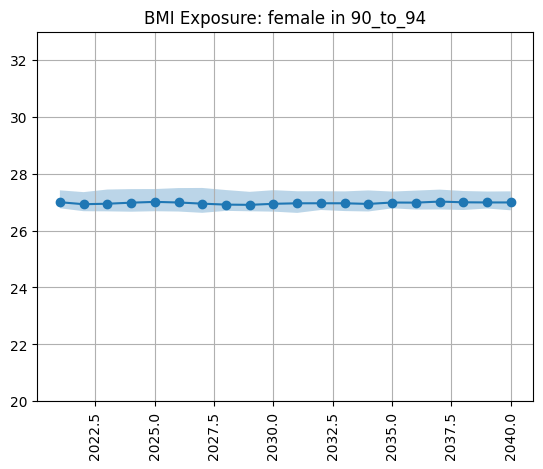

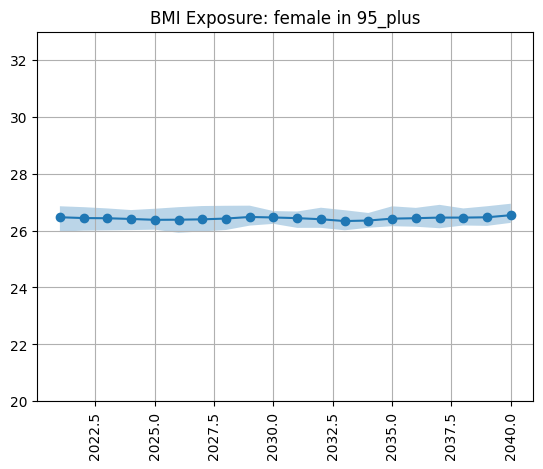

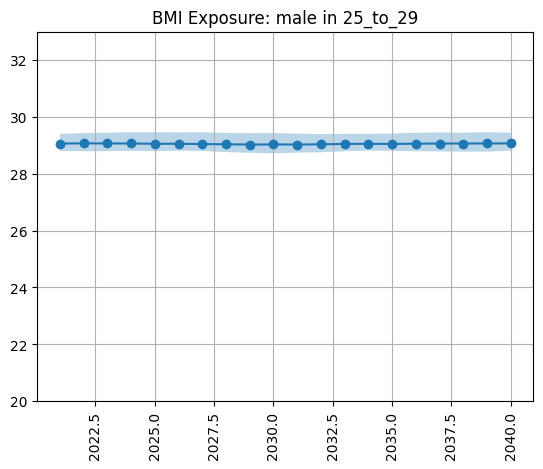

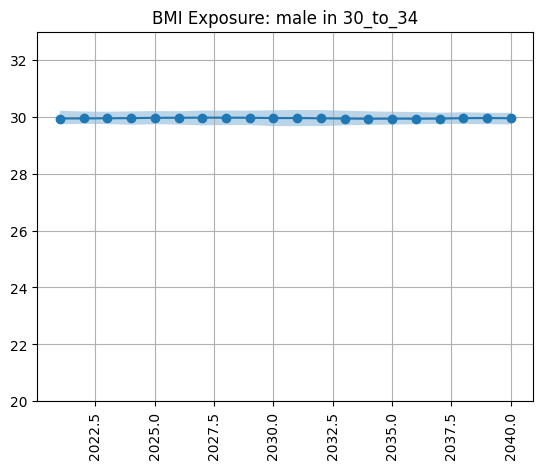

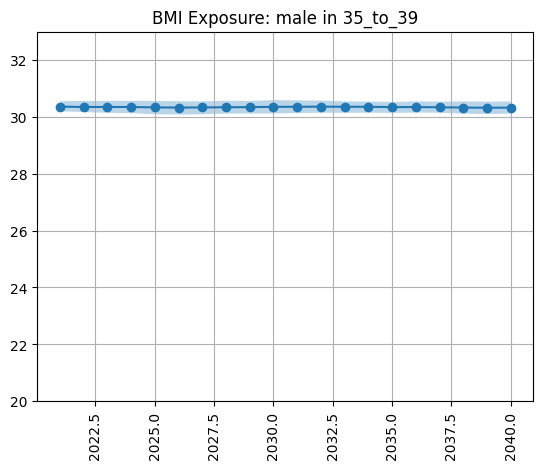

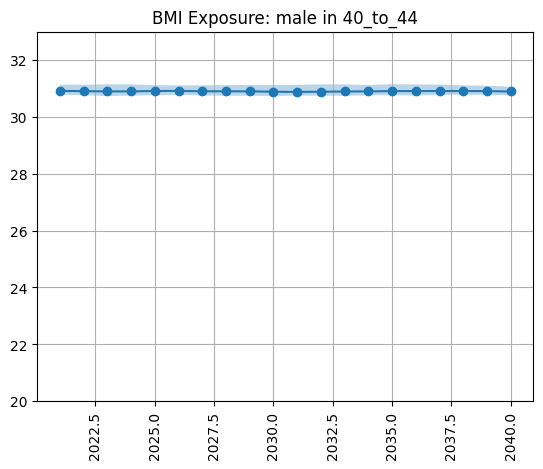

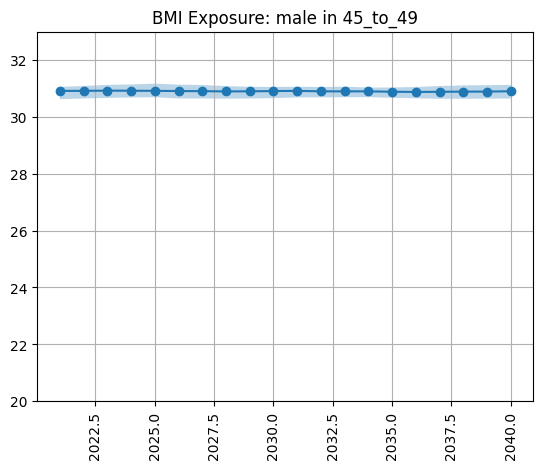

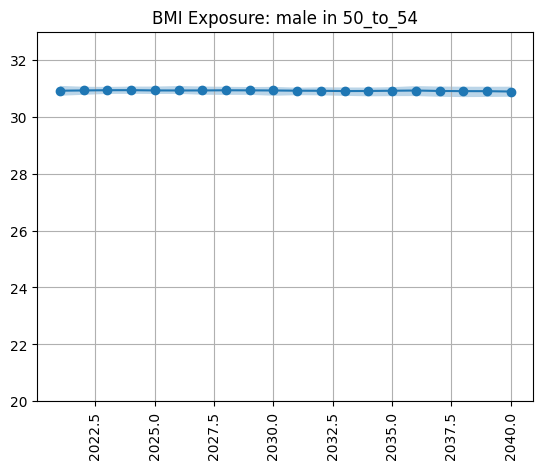

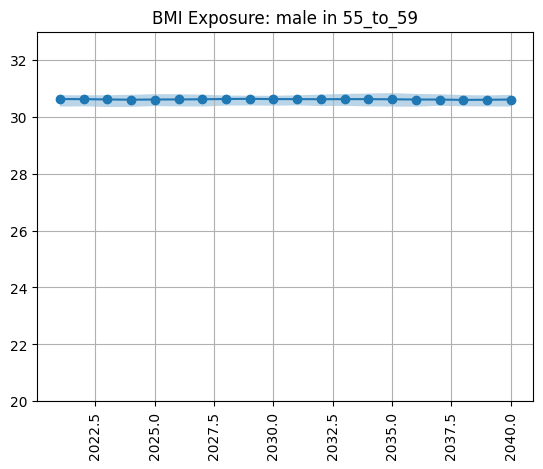

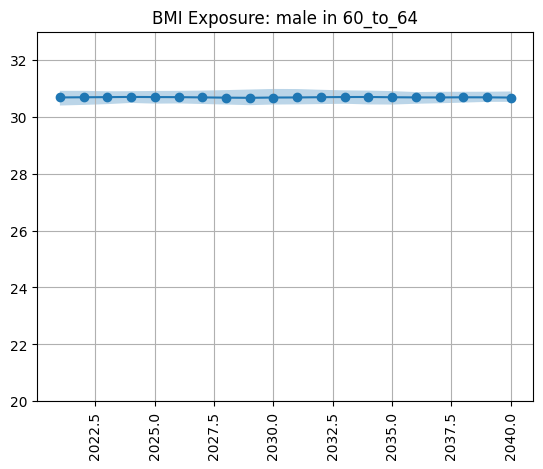

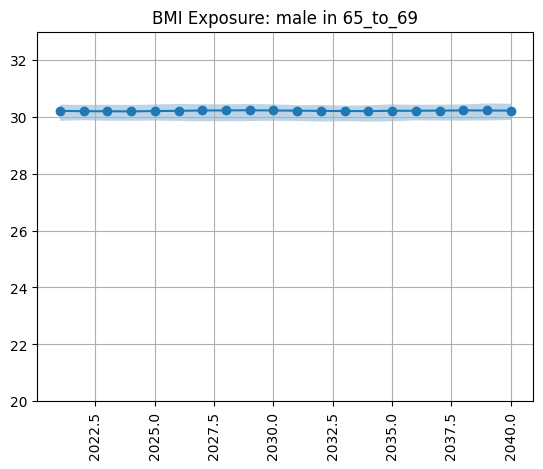

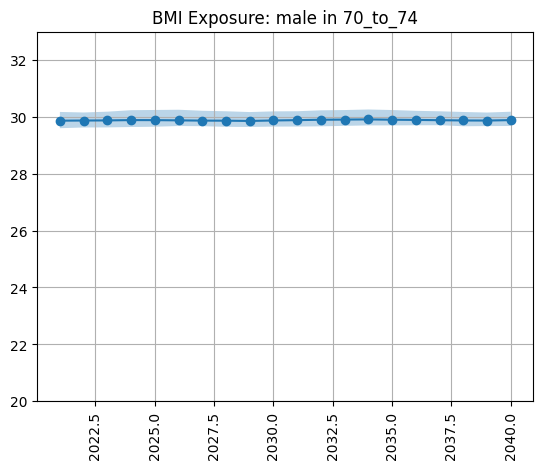

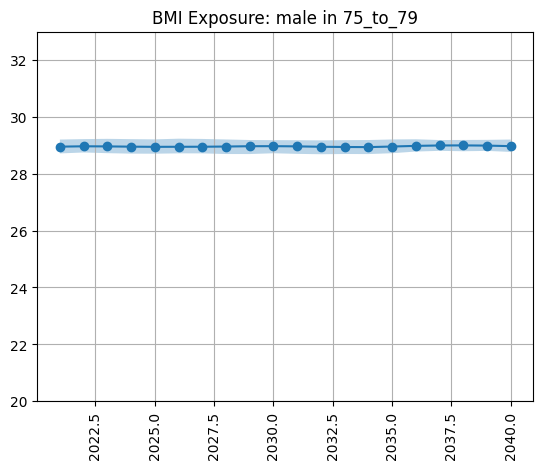

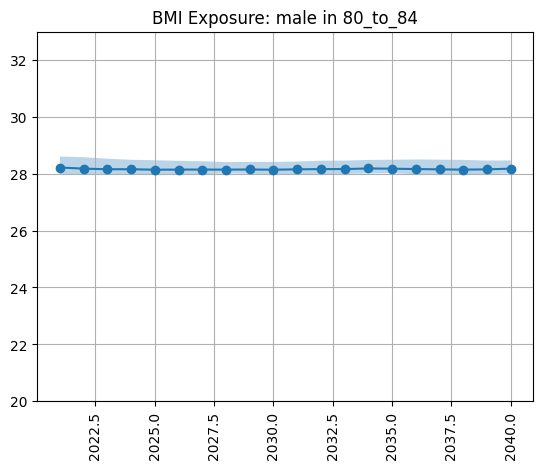

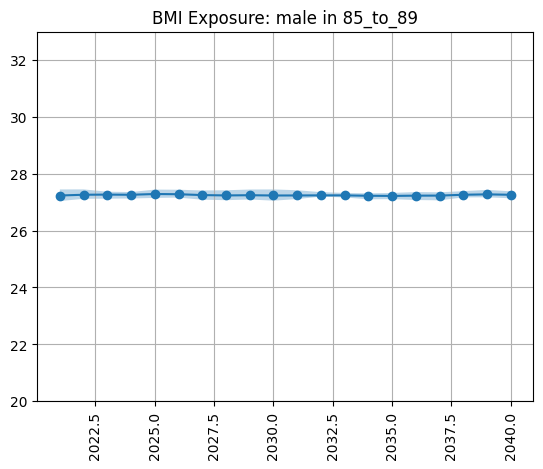

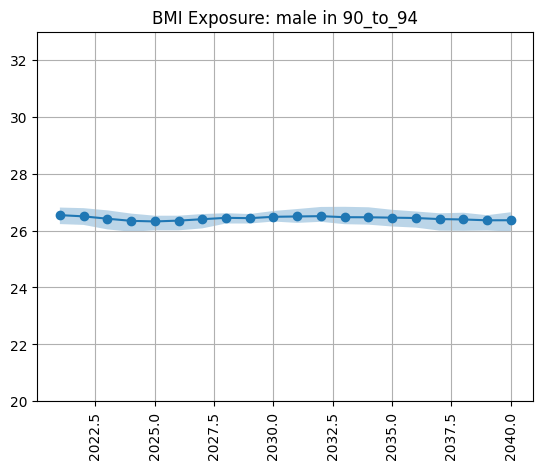

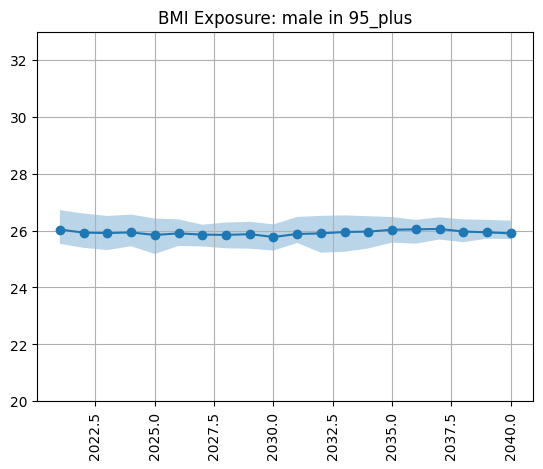

In [13]:
#%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(20,33)
        plt.grid()

Older people are getting lower BMI's overtime - that is bad 

### SBP 

In [14]:
sbp_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year','input_draw'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean','50%', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

age     sex  year  input_draw        mean         50%        2.5%  \
0  25_to_29  female  2021          29  107.860425  107.860425  107.860425   
1  25_to_29  female  2021         232  113.176642  113.176642  113.176642   
2  25_to_29  female  2021         357  110.767130  110.767130  110.767130   
3  25_to_29  female  2021         394  110.386681  110.386681  110.386681   
4  25_to_29  female  2021         602  111.478309  111.478309  111.478309   

        97.5%  
0  107.860425  
1  113.176642  
2  110.767130  
3  110.386681  
4  111.478309

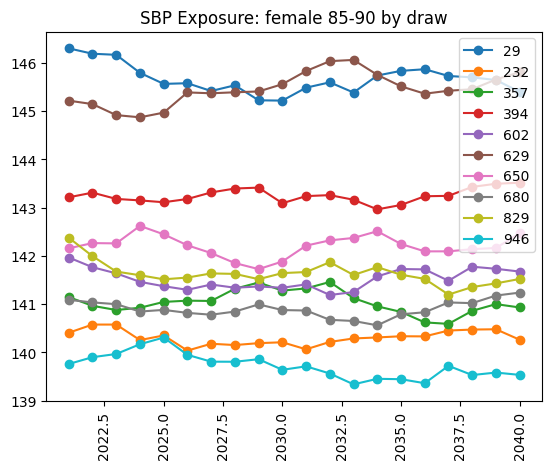

In [15]:
for draw in sbp_exp_rate_summ.input_draw.unique():
    #plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex=='female') & (sbp_exp_rate_summ.age=='85_to_89') & (sbp_exp_rate_summ.input_draw==draw)]
    plt.plot(subdata['year'], subdata['mean'], marker='o', label=draw)
    #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: female 85-90 by draw') 
    plt.xticks(rotation=90) 
    #plt.ylim(20,33)
    plt.grid()
    plt.legend()

In [16]:
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean','50%', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

age     sex  year        mean         50%        2.5%       97.5%
0  25_to_29  female  2021  110.149106  110.133110  107.982209  112.794517
1  25_to_29  female  2022  110.145523  110.168862  107.963476  112.820408
2  25_to_29  female  2023  110.148551  110.214152  107.949325  112.804183
3  25_to_29  female  2024  110.151034  110.244756  107.953211  112.811484
4  25_to_29  female  2025  110.151851  110.251030  107.942915  112.804062

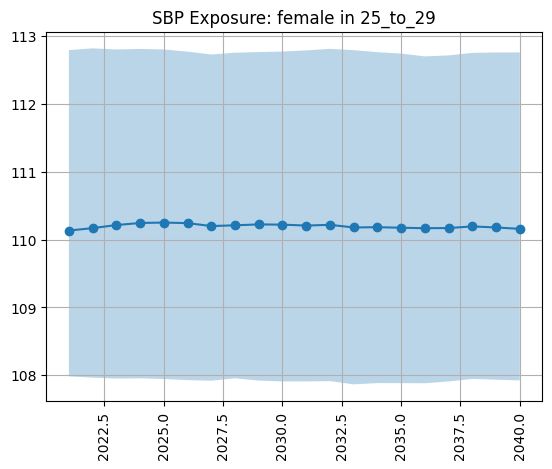

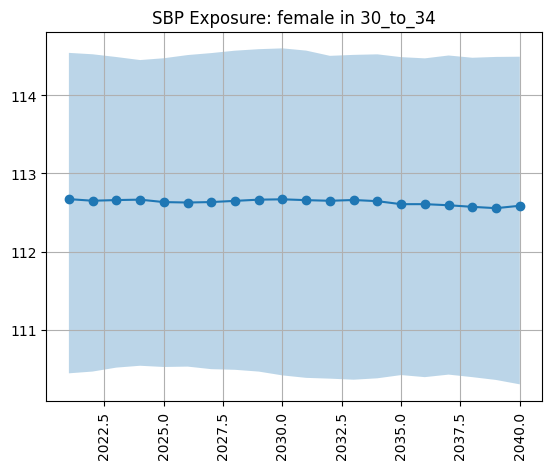

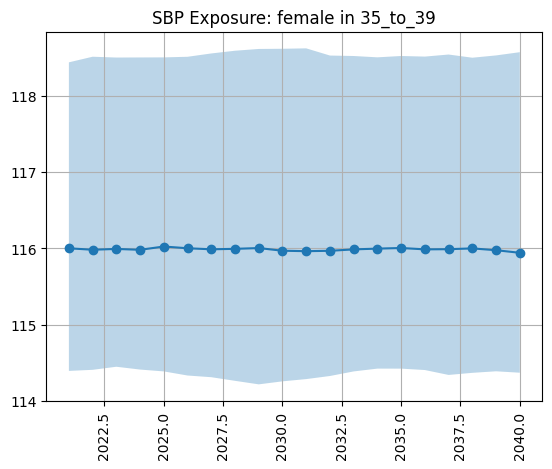

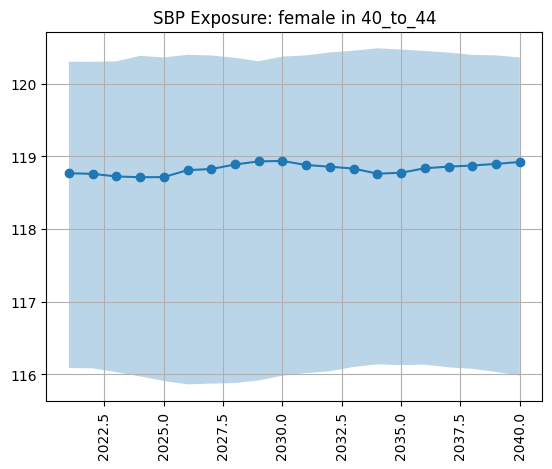

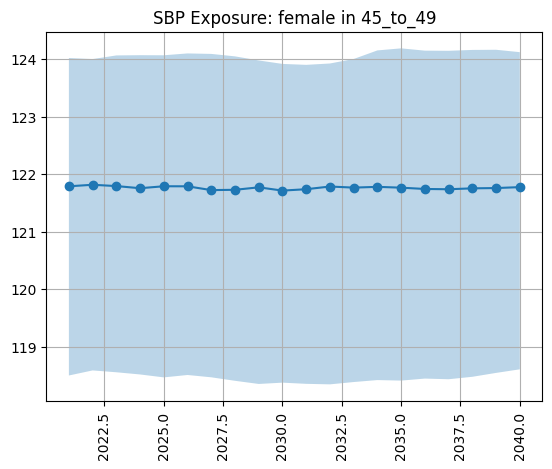

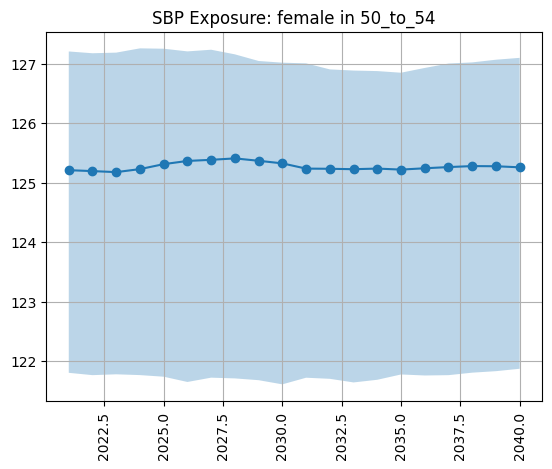

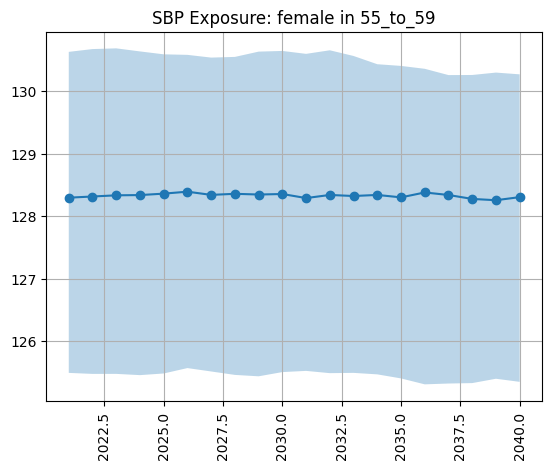

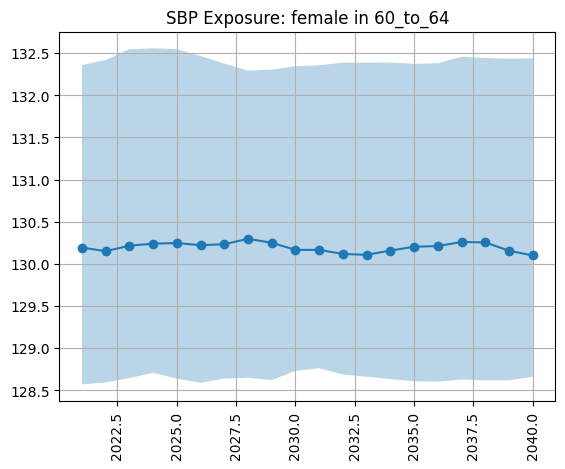

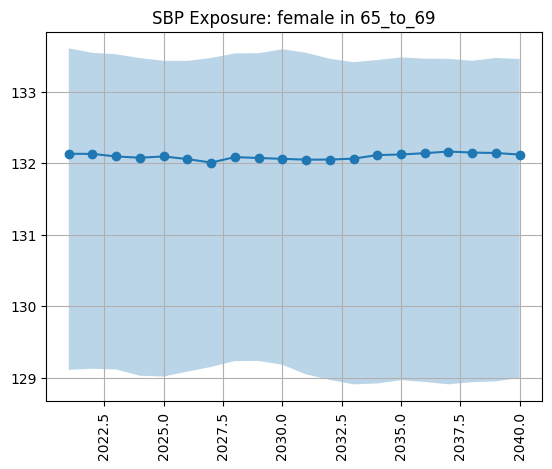

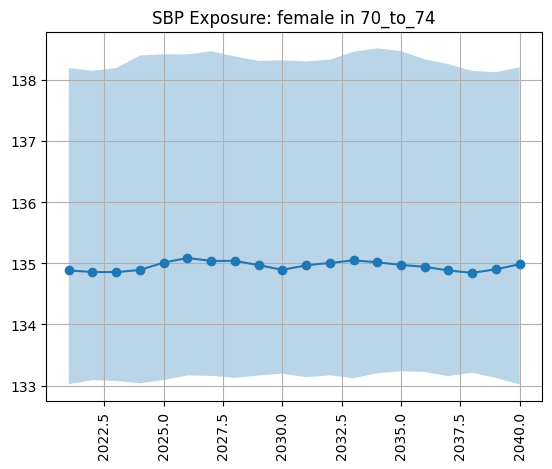

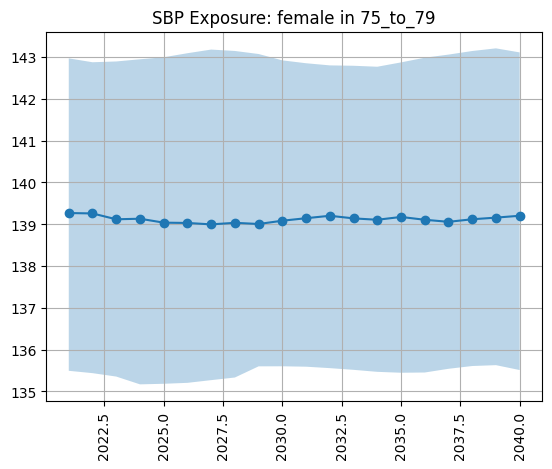

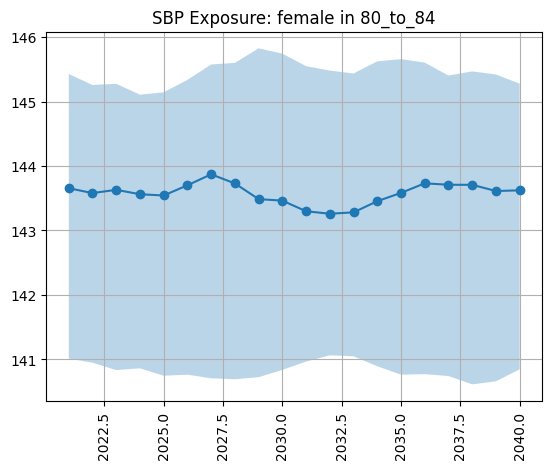

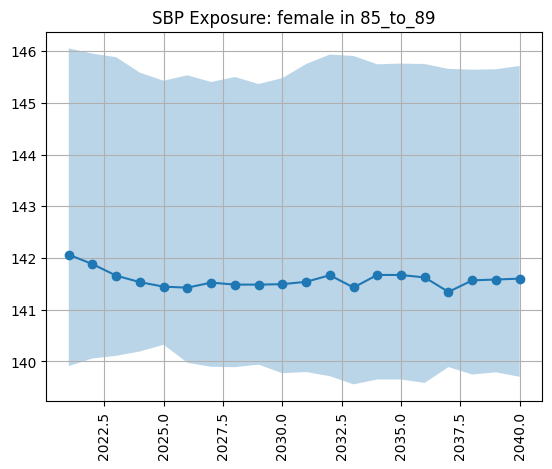

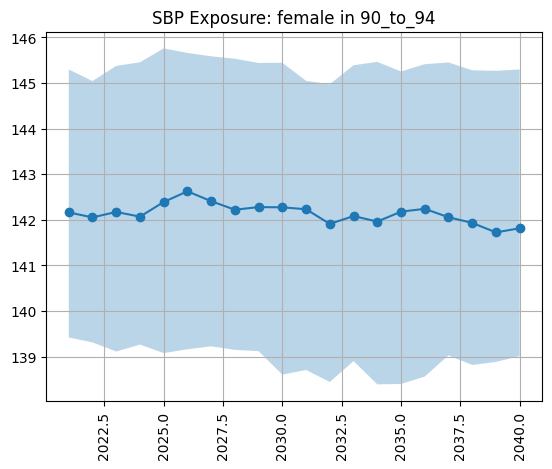

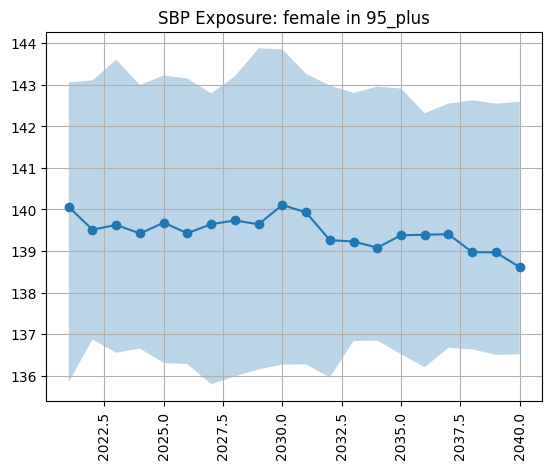

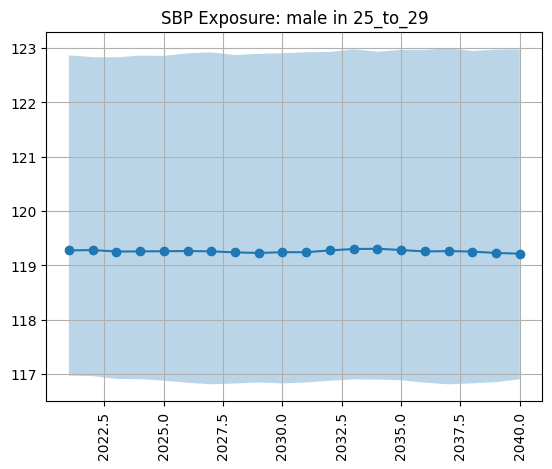

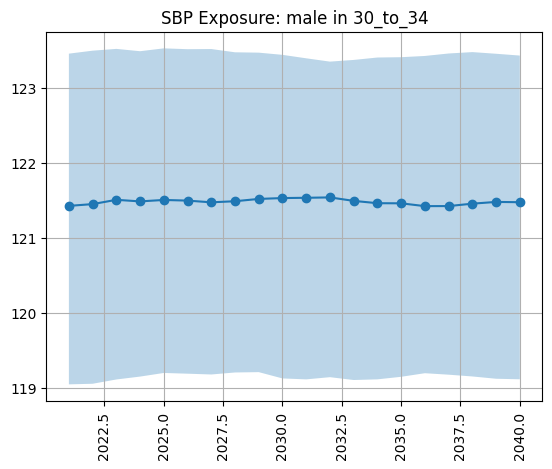

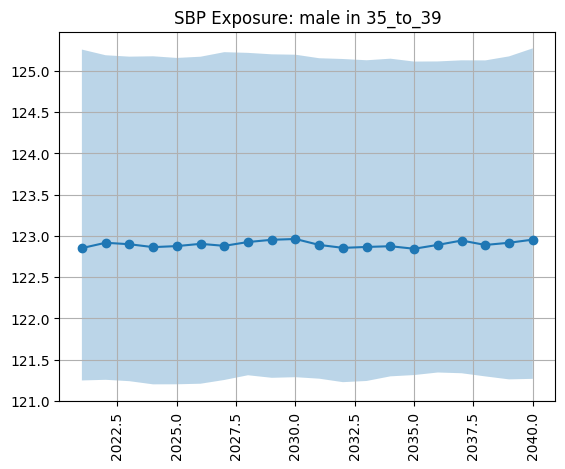

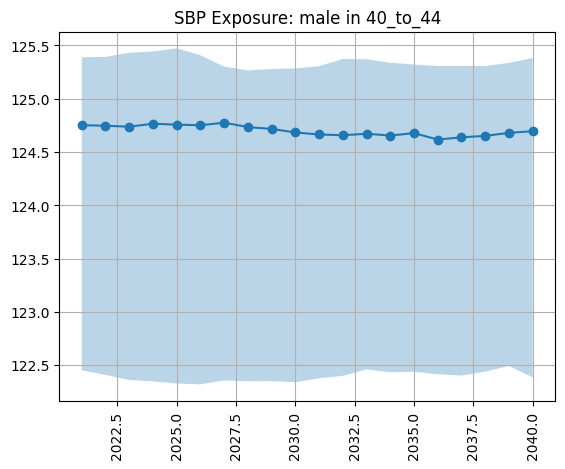

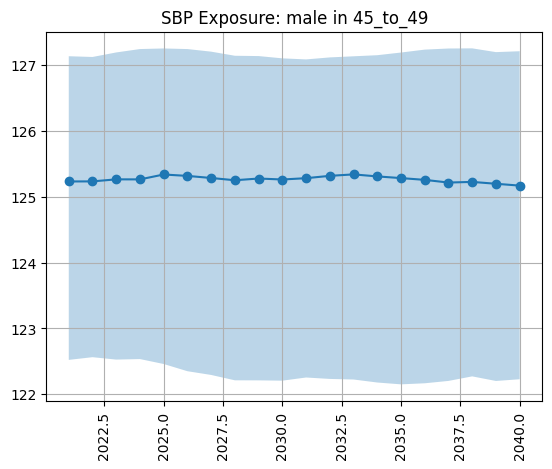

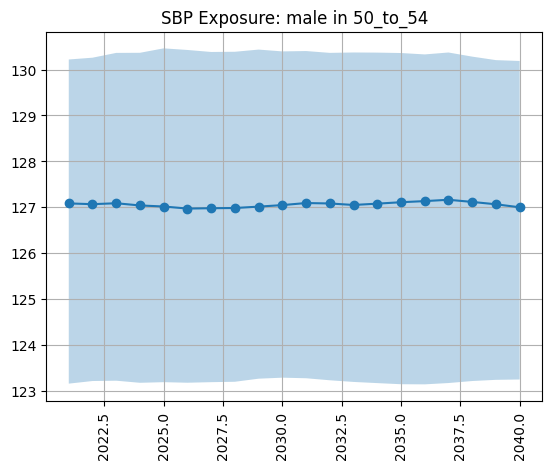

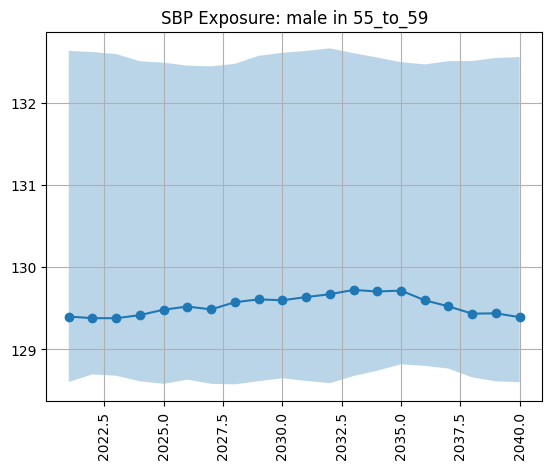

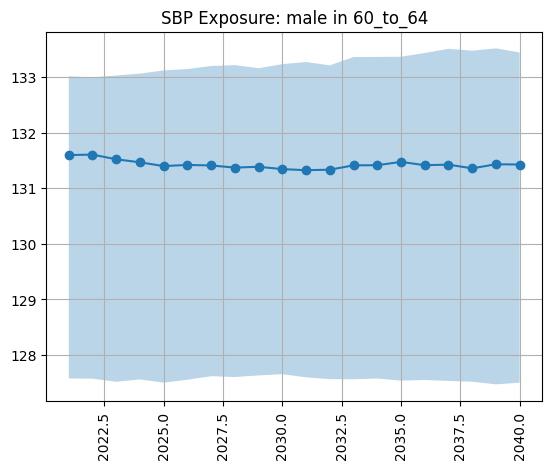

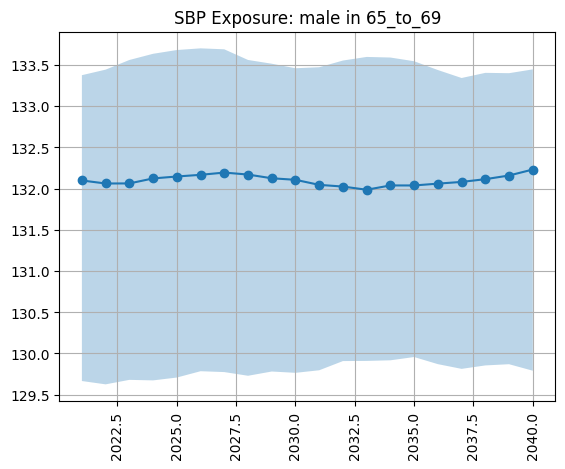

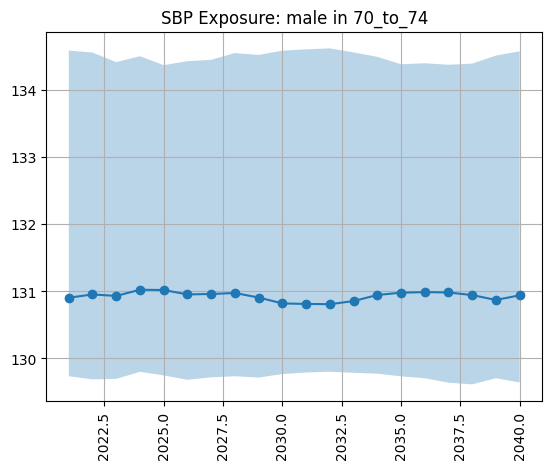

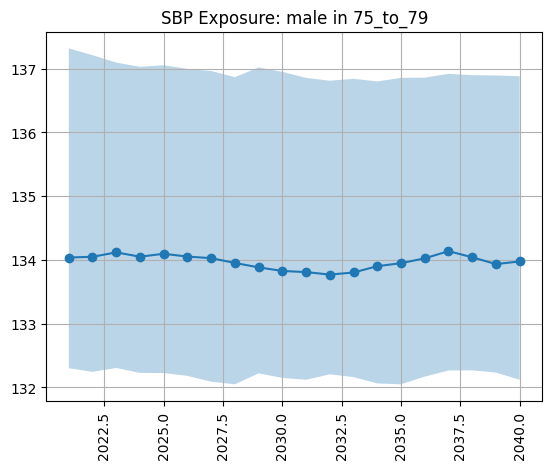

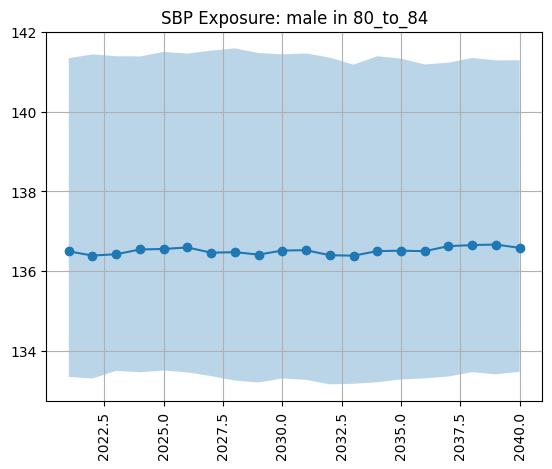

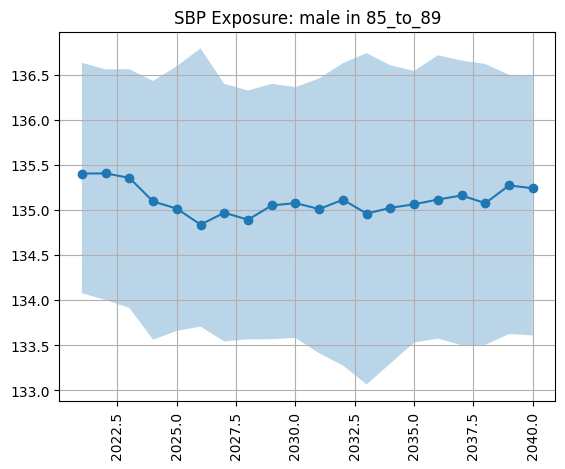

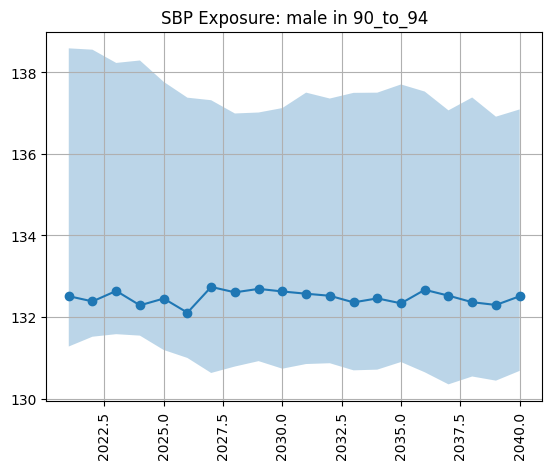

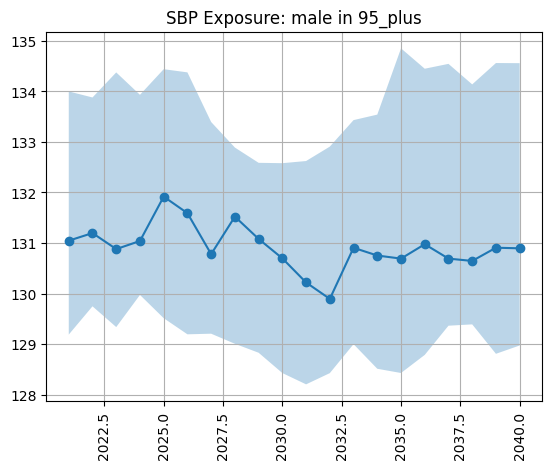

In [17]:
#%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['50%'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

This one is decreasing over time as well... 

### LDL-C

In [18]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2021  2.651510  2.573435  2.816242
1  25_to_29  female  2022  2.650806  2.573860  2.815605
2  25_to_29  female  2023  2.650164  2.573141  2.816579
3  25_to_29  female  2024  2.649298  2.570914  2.815674
4  25_to_29  female  2025  2.649133  2.574143  2.816680

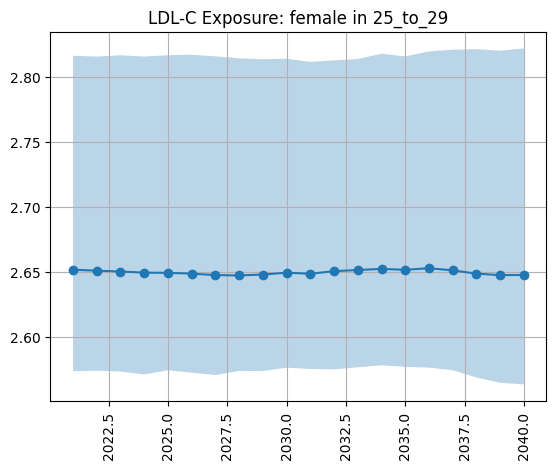

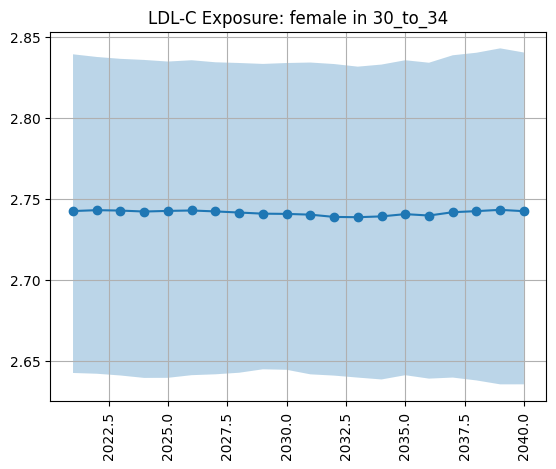

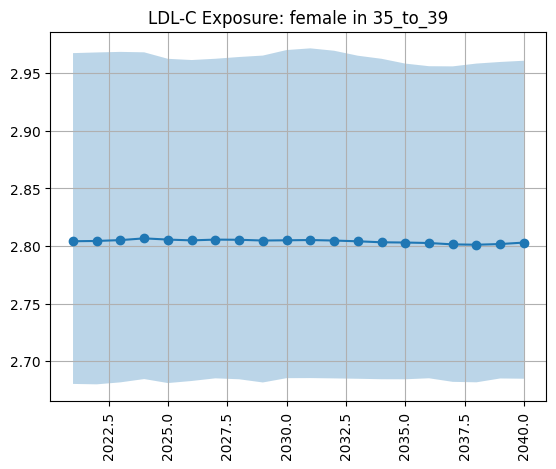

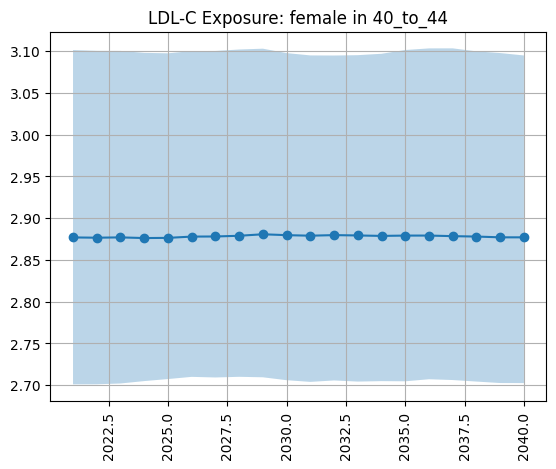

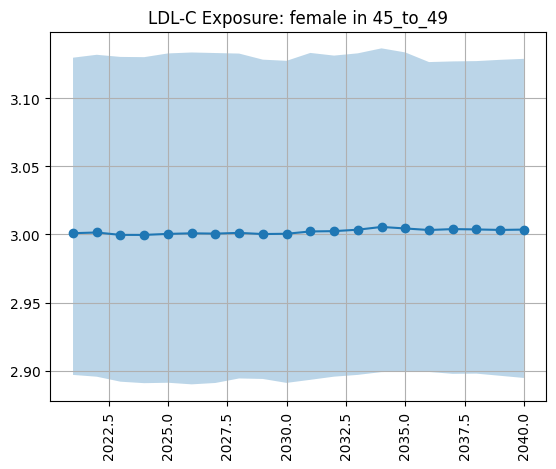

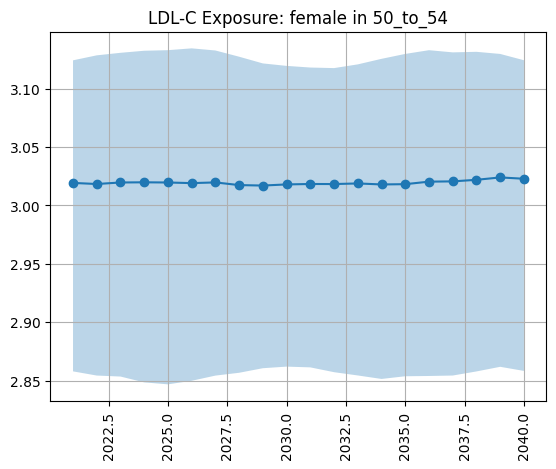

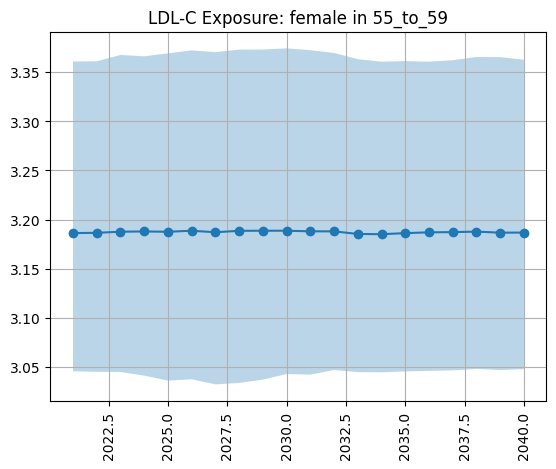

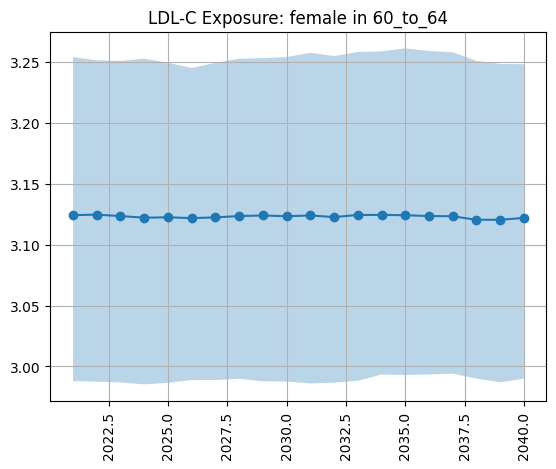

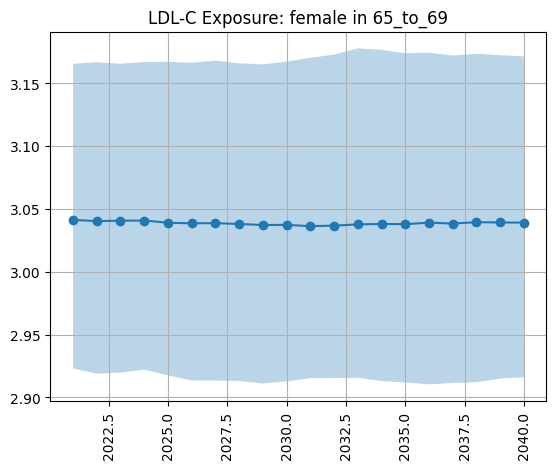

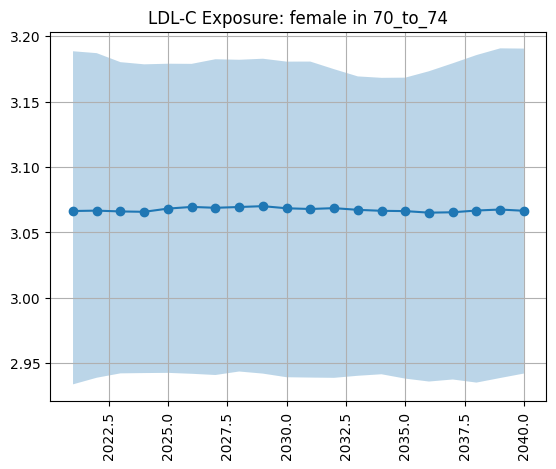

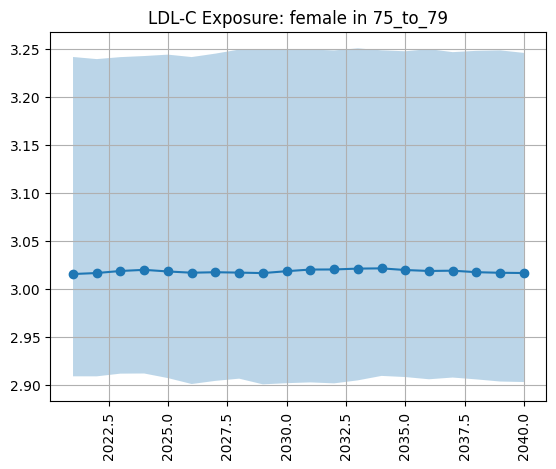

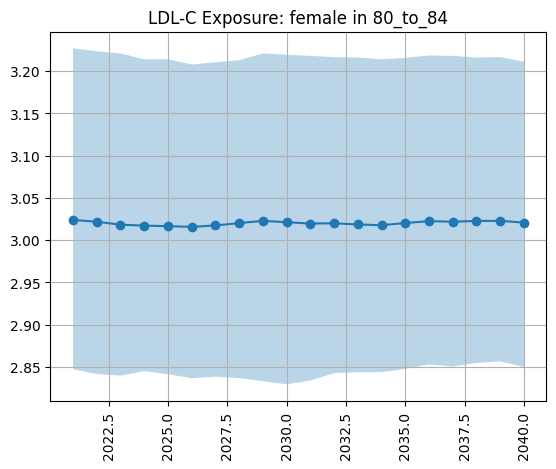

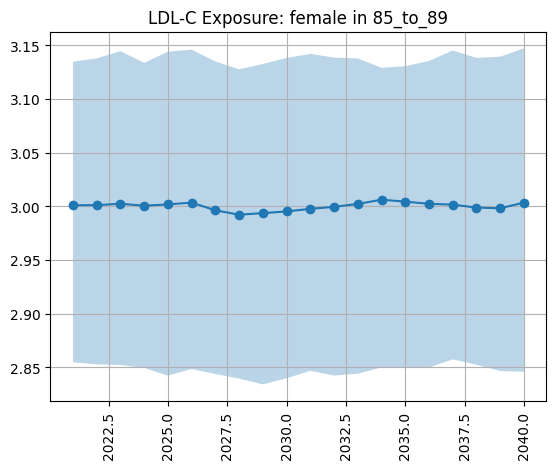

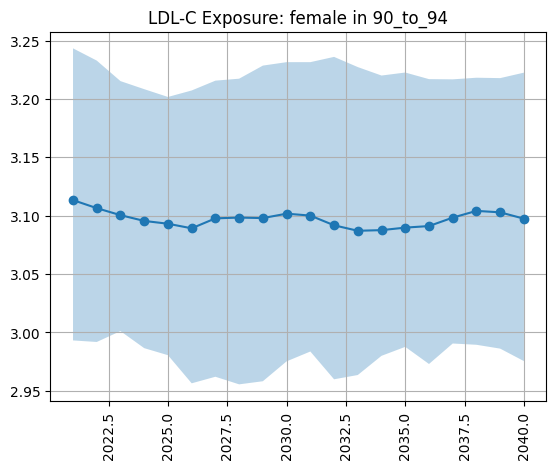

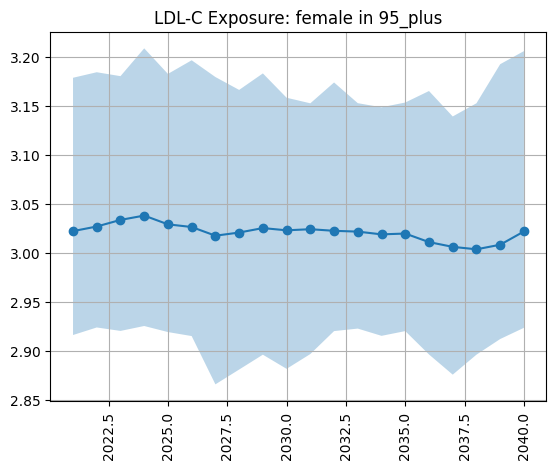

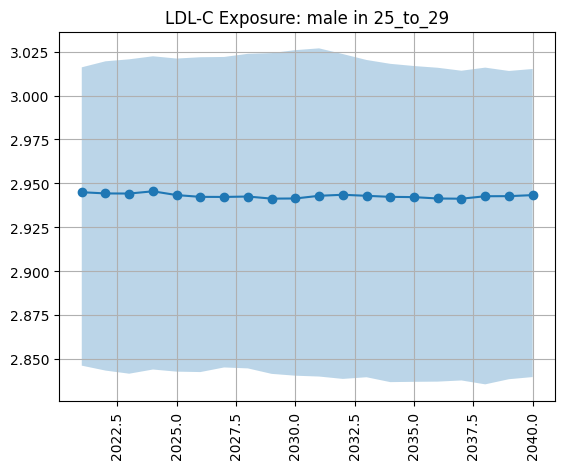

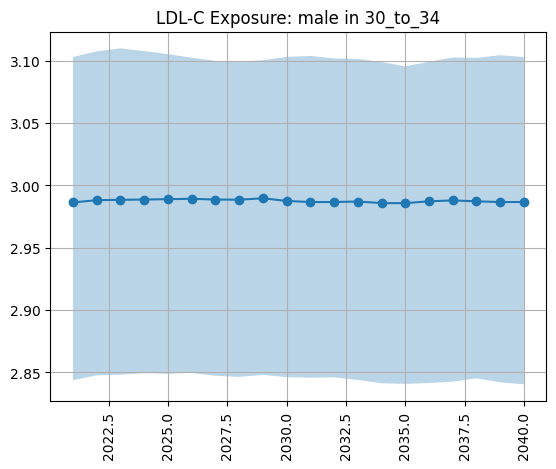

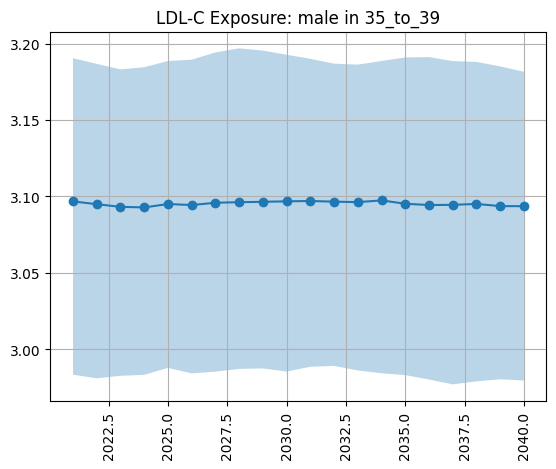

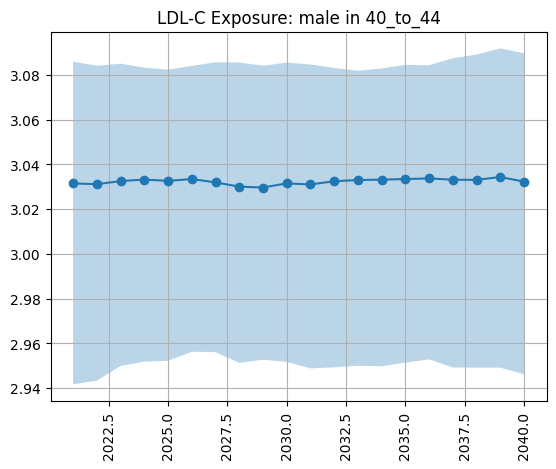

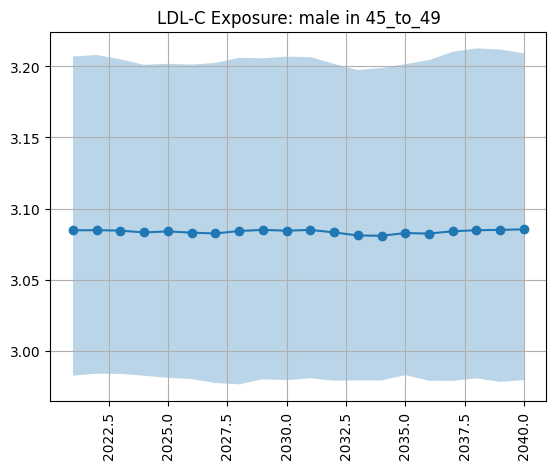

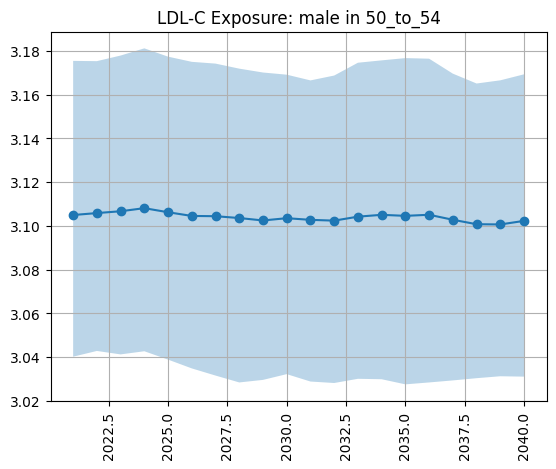

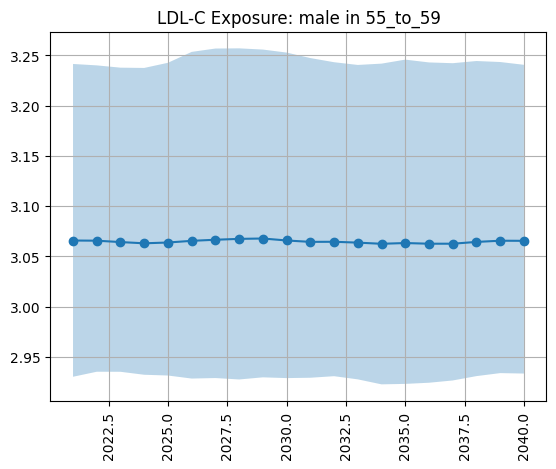

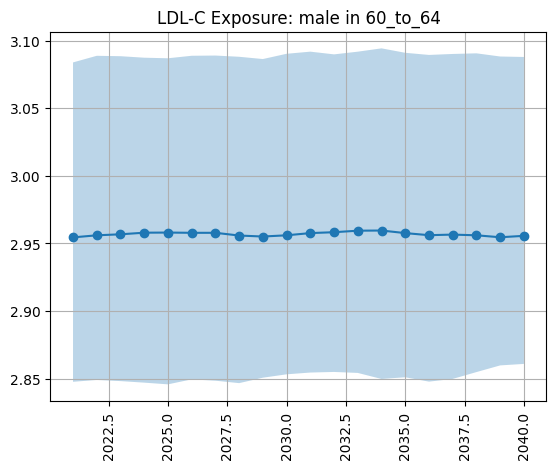

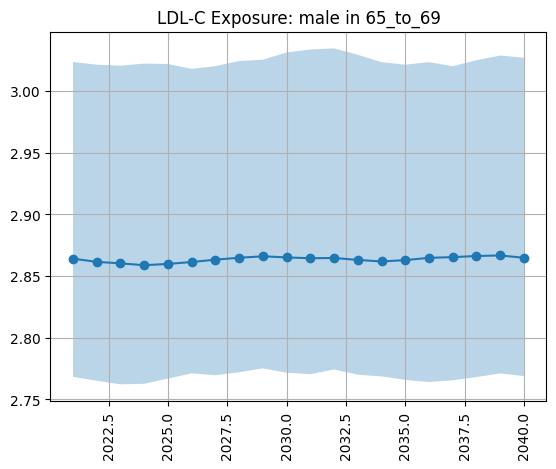

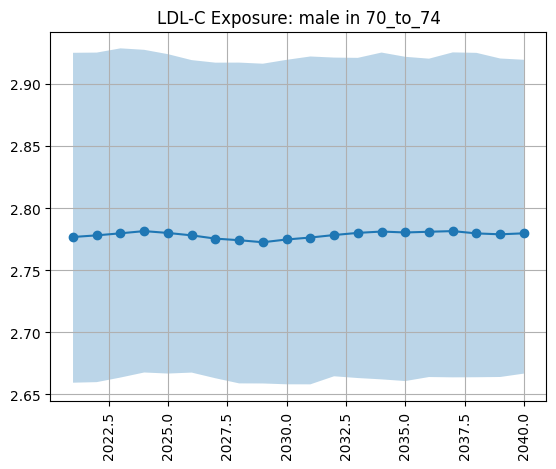

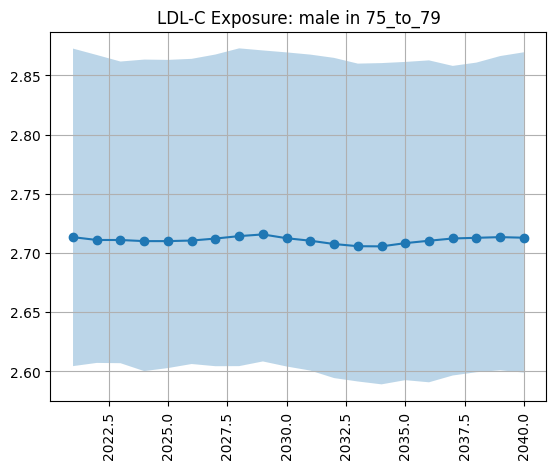

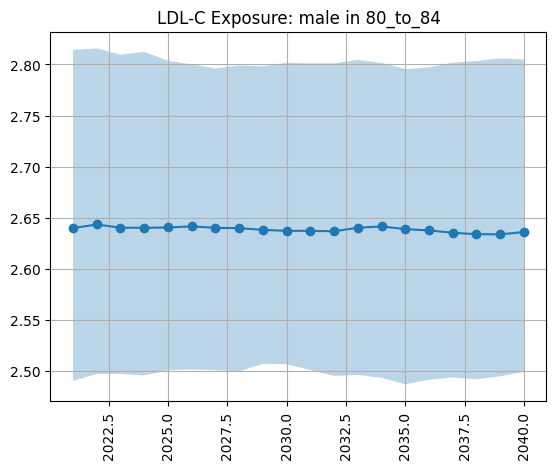

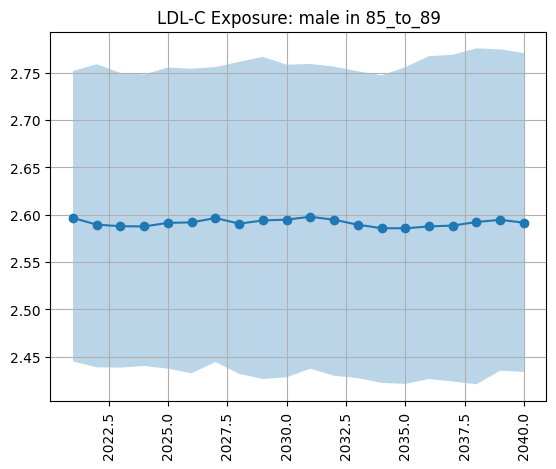

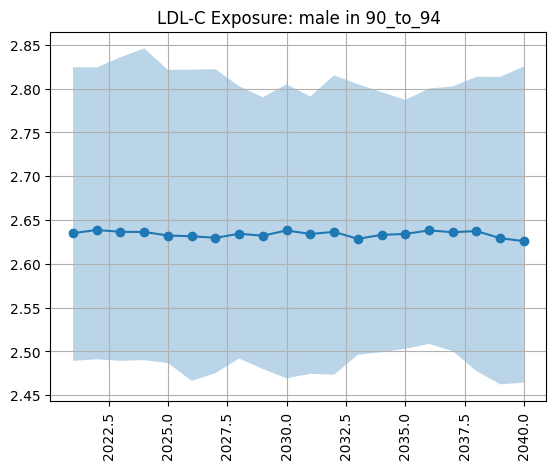

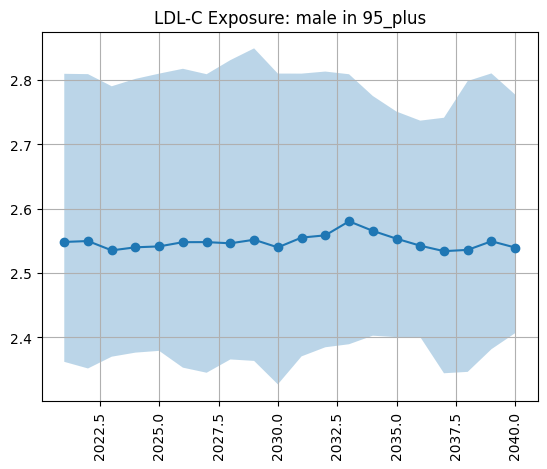

In [19]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

LDL-C increases in some age groups but decreases in the oldest age groups 

### FPG

In [20]:
fpg_exp = risk_exp.loc[risk_exp['risk']=='high_fasting_plasma_glucose']
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2021  5.342657  4.849425  6.190920
1  25_to_29  female  2022  5.343483  4.847846  6.192514
2  25_to_29  female  2023  5.342247  4.848373  6.188741
3  25_to_29  female  2024  5.339829  4.842159  6.185005
4  25_to_29  female  2025  5.340110  4.842752  6.182088

In [21]:
%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Even more interestingly, this one looks good and very stable over time 

## Comparison to Artifacts

In [10]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

51-locations/  alabama_before_calculated_pafs.hdf  washington.hdf
alabama.hdf    raw_data/


In [11]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [12]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

location     sex  age_start  age_end  year_start  year_end          value
0  Alabama  Female       25.0     30.0        2019      2020  171101.787730
1  Alabama  Female       30.0     35.0        2019      2020  162707.127245
2  Alabama  Female       35.0     40.0        2019      2020  160738.561697
3  Alabama  Female       40.0     45.0        2019      2020  151811.937430
4  Alabama  Female       45.0     50.0        2019      2020  160780.871213

In [25]:
#art.keys

In [13]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946']]

        # collapse to desired percentiles
        #data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [14]:
bmi_exp_rate.input_draw.unique()

array([ 29, 232, 357, 394, 602, 629, 650, 680, 829, 946])

### BMI

In [15]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art.reset_index(inplace=True)
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art['sex'] = np.where(bmi_art['sex'] == 'Female', 'female', 'male')
bmi_art#.head()

sex  age_start  age_end  year_start  year_end   parameter    draw_29  \
0   female       25.0     30.0        2019      2020  continuous  31.040729   
1   female       30.0     35.0        2019      2020  continuous  31.687780   
2   female       35.0     40.0        2019      2020  continuous  31.579826   
3   female       40.0     45.0        2019      2020  continuous  32.027424   
..     ...        ...      ...         ...       ...         ...        ...   
26    male       80.0     85.0        2019      2020  continuous  28.343667   
27    male       85.0     90.0        2019      2020  continuous  27.776862   
28    male       90.0     95.0        2019      2020  continuous  27.181793   
29    male       95.0    125.0        2019      2020  continuous  26.306390   

     draw_232   draw_357   draw_394   draw_602   draw_629   draw_650  \
0   30.479341  30.730216  30.815550  30.820311  31.098089  30.647594   
1   31.744684  31.741180  31.602855  31.815107  31.576473  31.336760   
2   31.829366  31.799881  31.971675  32.056858  31.755398  31.909627   
3   32.189413  32.282056  32.049680  32.464513  32.434235  32.268614   
..        ...        ...        ...        ...        ...        ...   
26  28.284646  28.215973  28.268678  28.214379  28.659202  28.700720   
27  27.557366  27.411122  27.633937  27.562675  27.591425  27.728124   
28  26.723049  26.851961  27.106339  26.757355  26.591969  27.111183   
29  26.903680  26.659047  26.609987  26.465789  26.816294  26.885996   

     draw_680   draw_829   draw_946 location   measure  age_group  
0   30.724949  31.003332  30.985529  Alabama  exposure   25_to_29  
1   31.394354  31.478414  31.387163  Alabama  exposure   30_to_34  
2   31.773295  31.729673  31.830362  Alabama  exposure   35_to_39  
3   32.453380  32.099844  32.129270  Alabama  exposure   40_to_44  
..        ...        ...        ...      ...       ...        ...  
26  28.226716  28.418730  28.517684  Alabama  exposure   80_to_84  
27  27.531090  27.623903  27.611298  Alabama  exposure   85_to_89  
28  26.639555  27.126383  27.054017  Alabama  exposure   90_to_94  
29  26.546214  26.642405  26.319751  Alabama  exposure  95_to_124  

[30 rows x 19 columns]

KeyError: '50%'

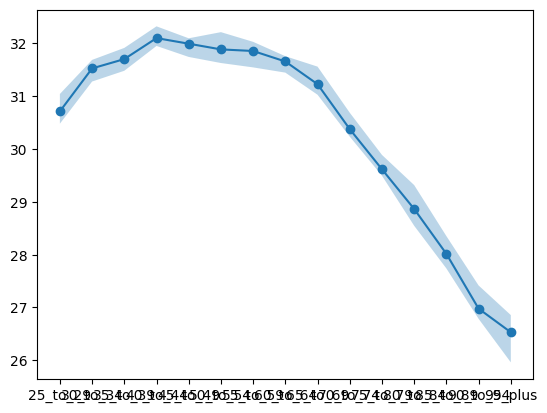

In [16]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2021)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

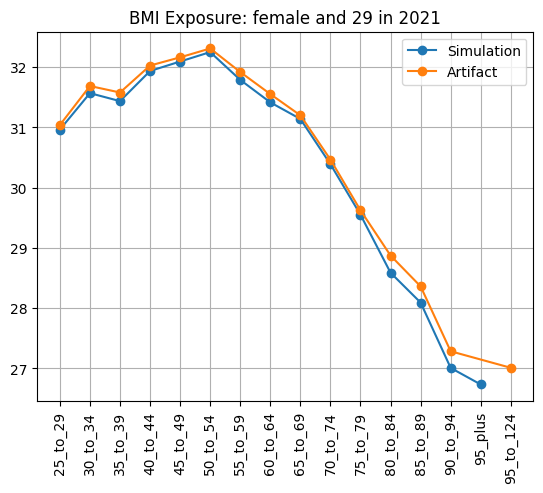

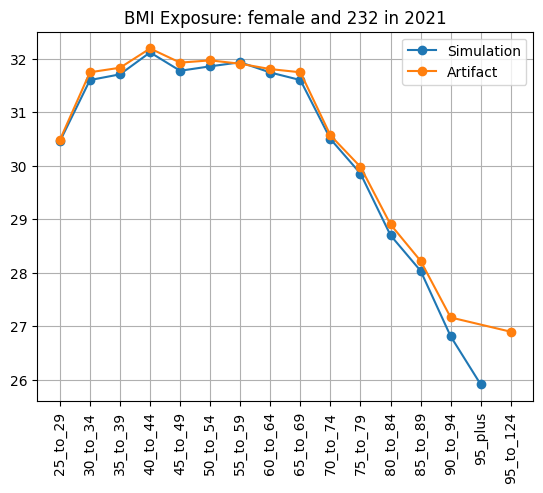

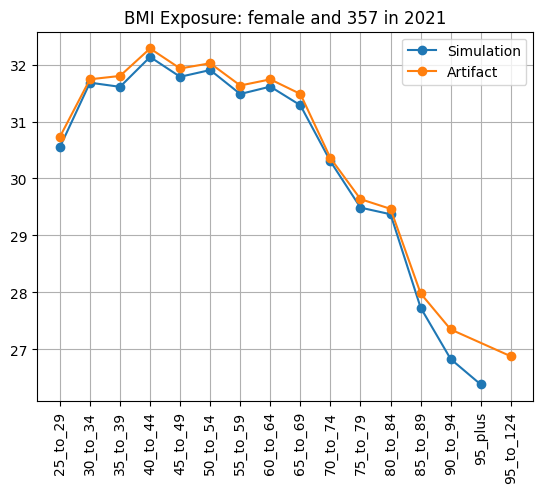

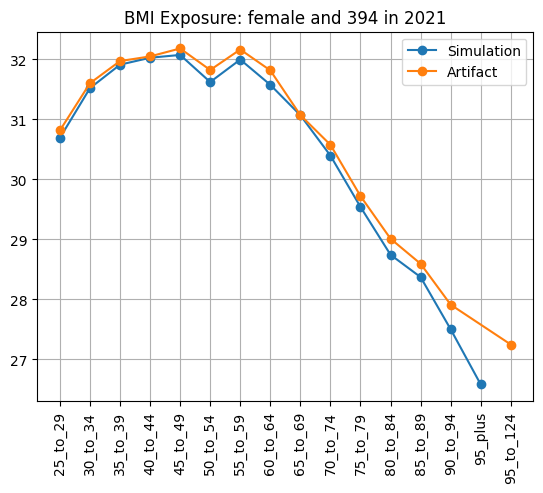

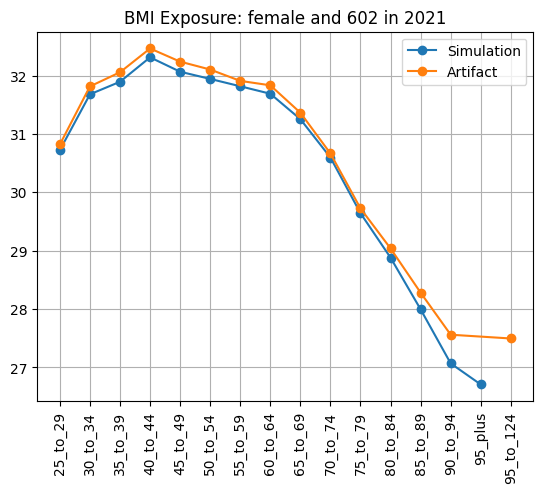

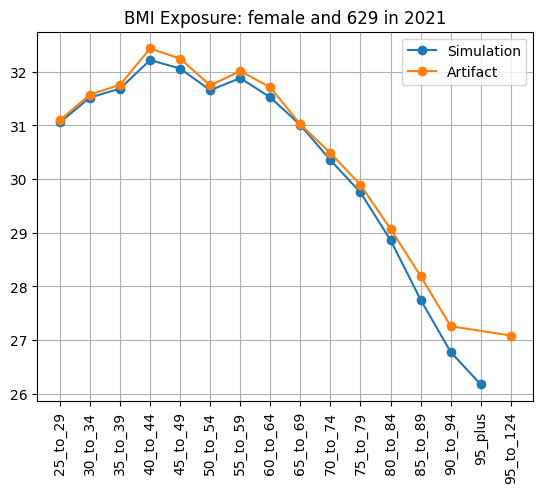

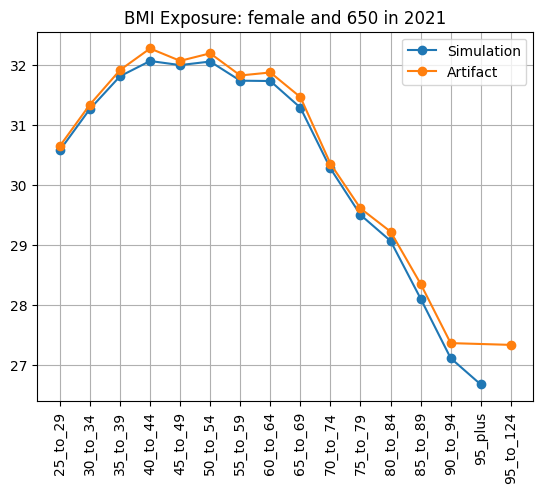

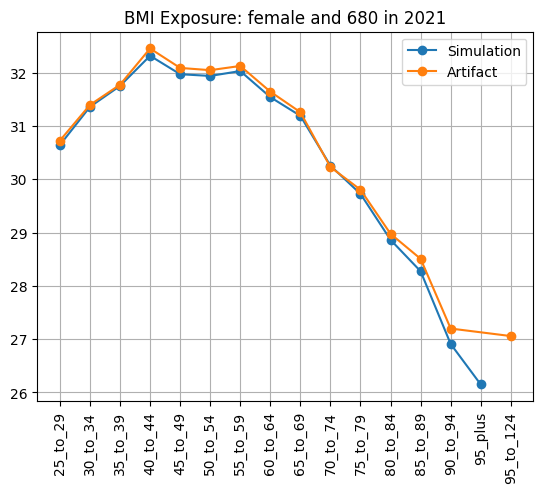

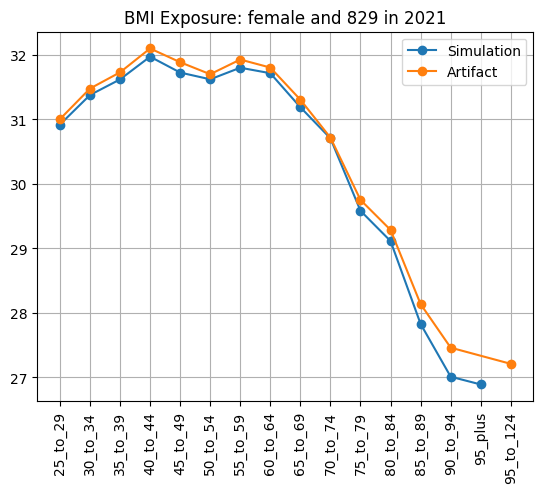

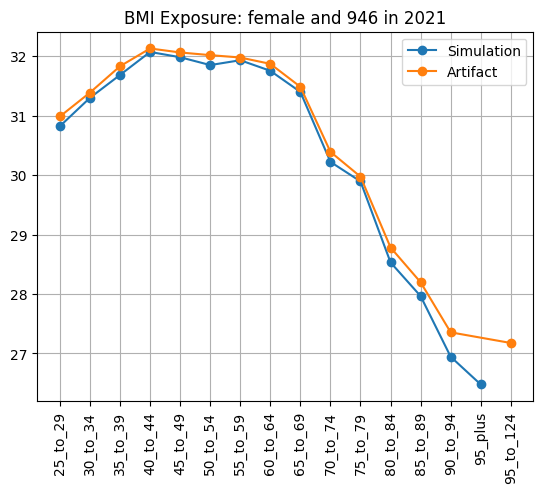

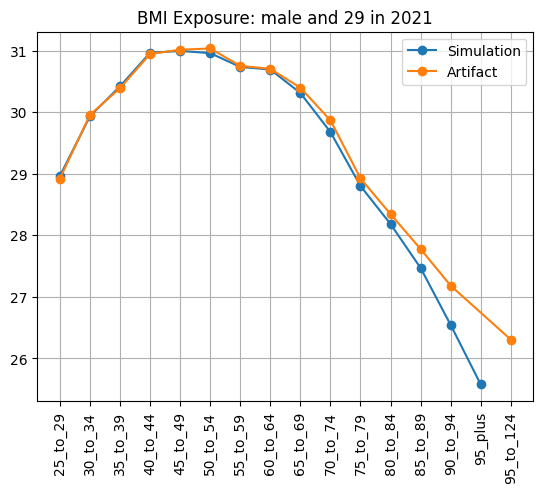

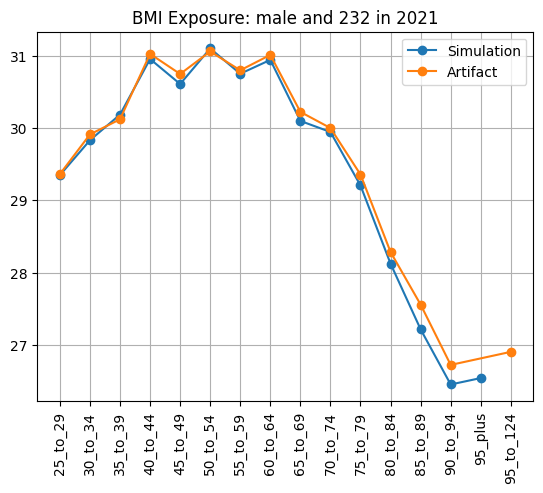

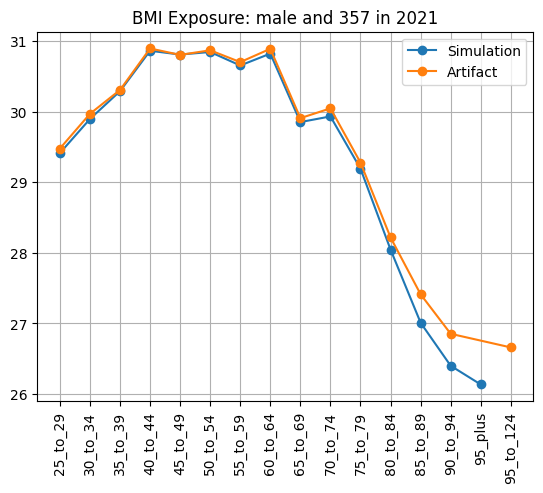

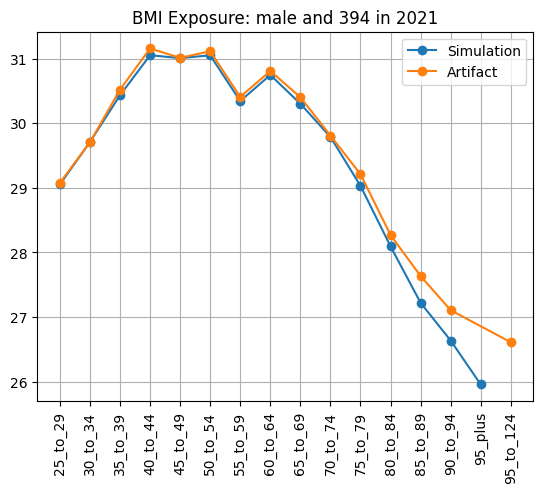

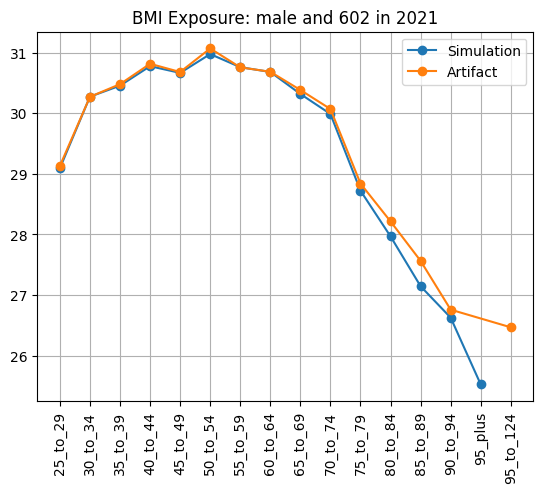

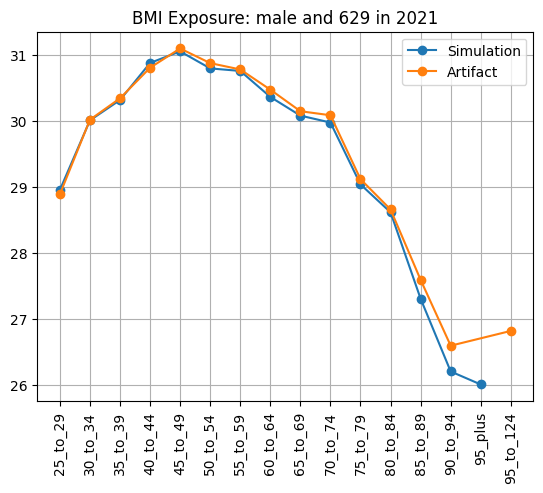

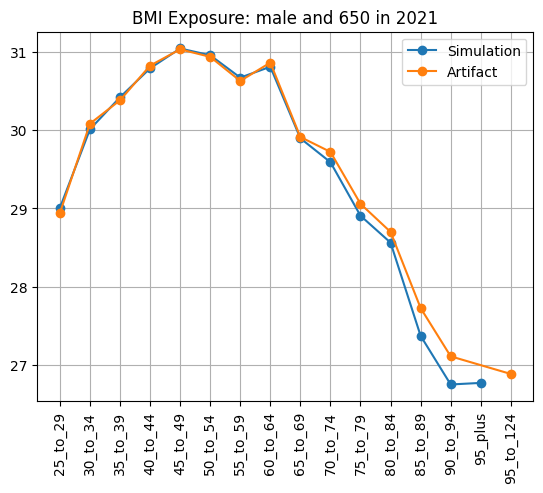

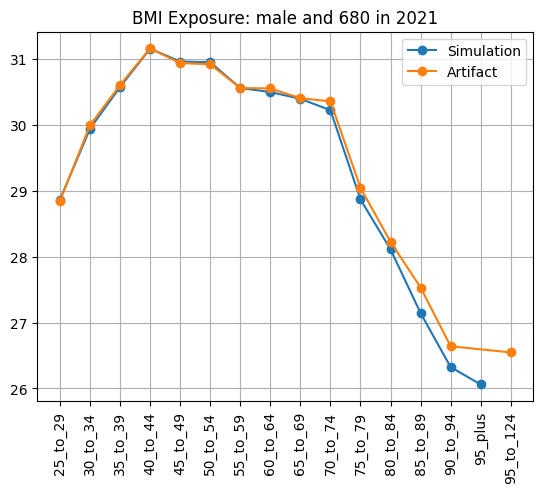

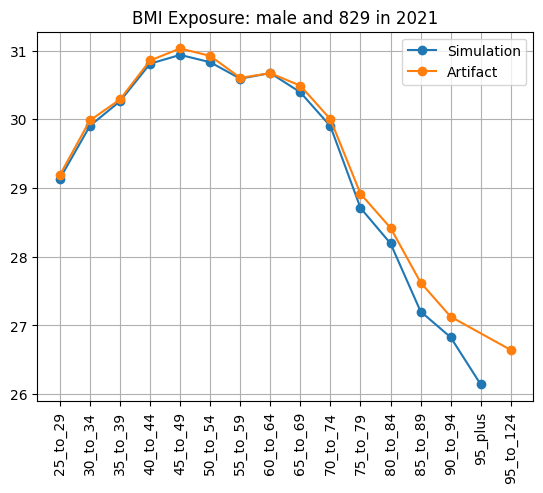

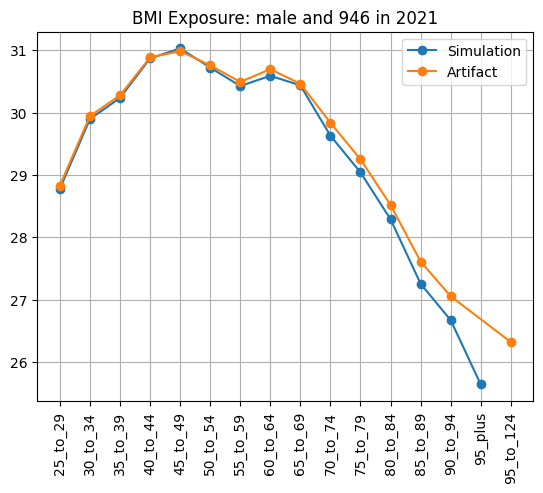

In [17]:
for sex in bmi_exp_rate.sex.unique():
    for draw in bmi_exp_rate.input_draw.unique():
        plt.figure() 
        subdata = bmi_exp_rate.loc[(bmi_exp_rate.input_draw==draw) & (bmi_exp_rate.sex==sex) & (bmi_exp_rate.year==2021)]
        plt.plot(subdata['age'], subdata['bmi_rate'], marker='o')
        subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
        string = 'draw_'+ str(draw)
        plt.plot(subdata2['age_group'], subdata2[string], marker='o')
        plt.title(f'BMI Exposure: {sex} and {draw} in 2021') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()
        plt.legend(['Simulation', 'Artifact']) 

In [ ]:
bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]

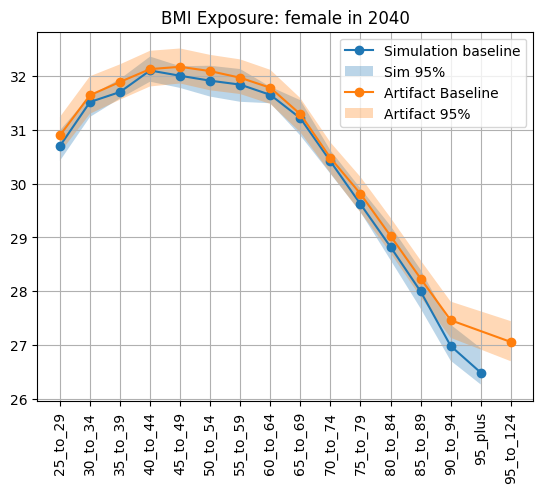

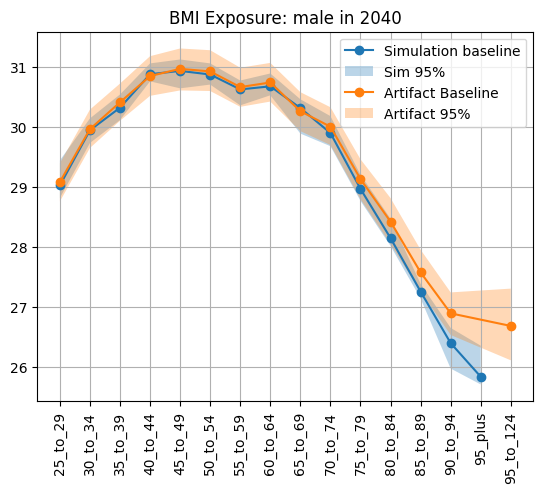

In [29]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [30]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

sex  age_start  age_end  year_start  year_end   parameter        mean  \
0  female       25.0     30.0        2019      2020  continuous  110.635893   
1  female       30.0     35.0        2019      2020  continuous  112.876275   
2  female       35.0     40.0        2019      2020  continuous  116.139886   
3  female       40.0     45.0        2019      2020  continuous  118.491616   
4  female       45.0     50.0        2019      2020  continuous  121.645391   

          50%        2.5%       97.5% location   measure age_group  
0  110.623634  107.945700  113.550750  Alabama  exposure  25_to_29  
1  112.881309  110.098198  115.523727  Alabama  exposure  30_to_34  
2  116.134678  113.594023  118.770064  Alabama  exposure  35_to_39  
3  118.514616  115.903577  121.039457  Alabama  exposure  40_to_44  
4  121.618436  118.875235  124.529834  Alabama  exposure  45_to_49

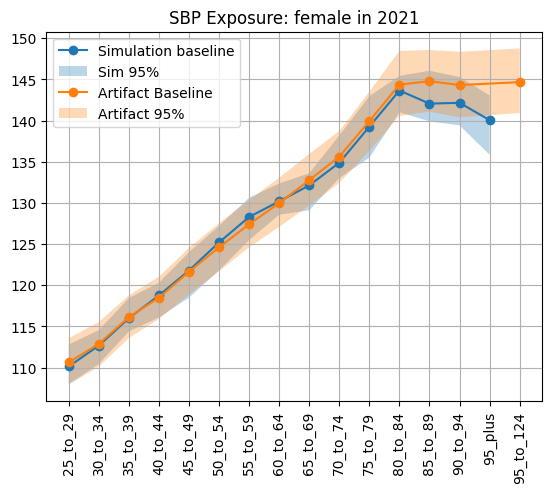

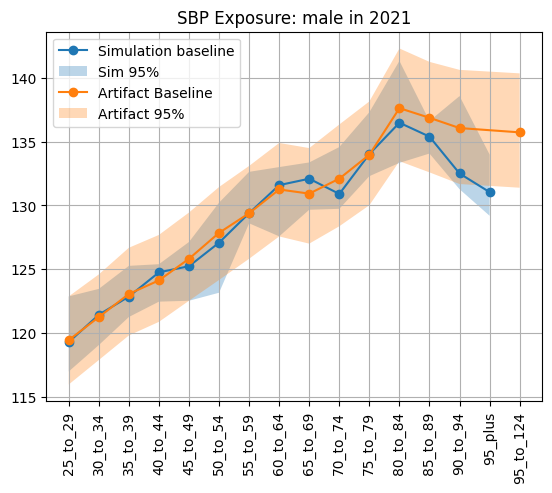

In [43]:
#Can we stratify by medication coverage? 

for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2021)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2021')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

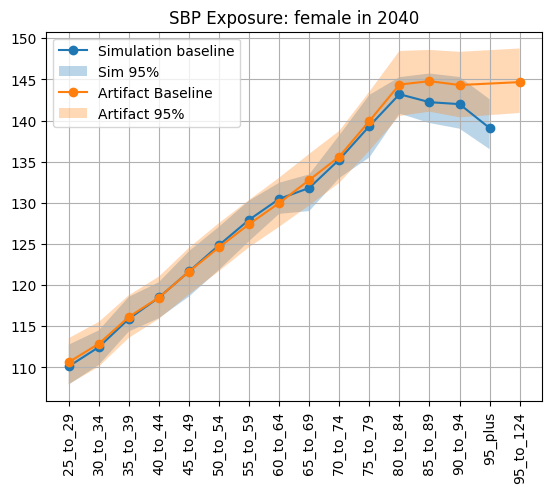

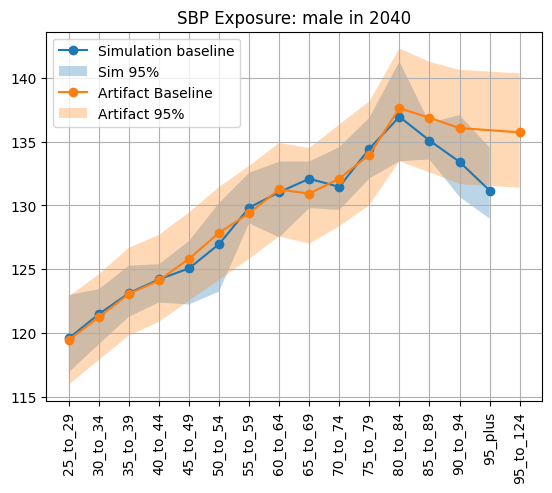

In [32]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [33]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  female       25.0     30.0        2019      2020  continuous  2.639862   
1  female       30.0     35.0        2019      2020  continuous  2.724353   
2  female       35.0     40.0        2019      2020  continuous  2.802925   
3  female       40.0     45.0        2019      2020  continuous  2.880791   
4  female       45.0     50.0        2019      2020  continuous  2.998297   

        50%      2.5%     97.5% location   measure age_group  
0  2.638003  2.472574  2.821188  Alabama  exposure  25_to_29  
1  2.723671  2.553736  2.905134  Alabama  exposure  30_to_34  
2  2.801341  2.639513  2.972487  Alabama  exposure  35_to_39  
3  2.878250  2.721814  3.039119  Alabama  exposure  40_to_44  
4  2.995129  2.837974  3.175367  Alabama  exposure  45_to_49

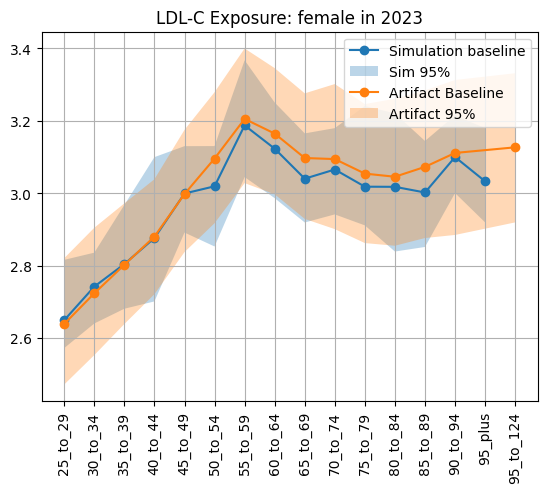

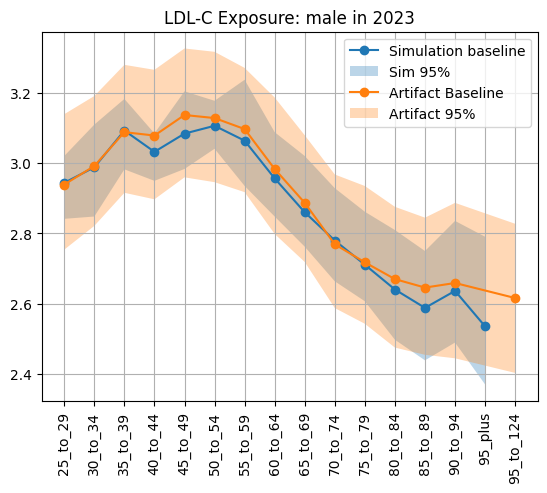

In [34]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

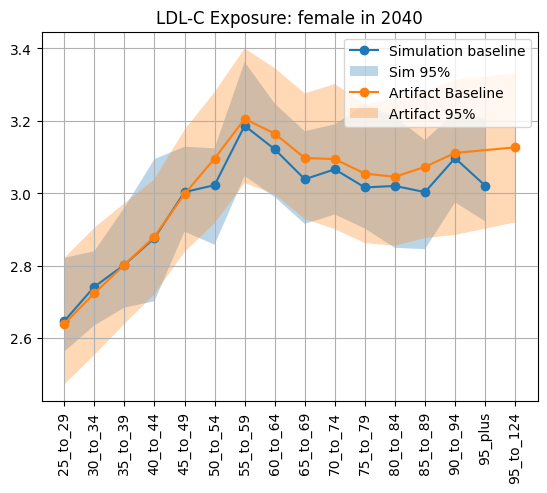

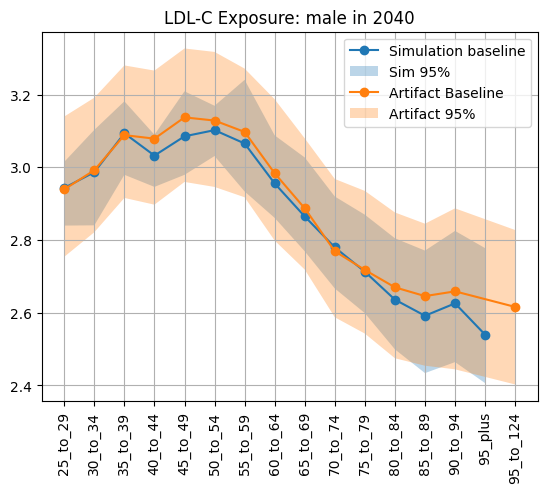

In [35]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [36]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  female       25.0     30.0        2019      2020  continuous  5.316303   
1  female       30.0     35.0        2019      2020  continuous  5.461718   
2  female       35.0     40.0        2019      2020  continuous  5.538952   
3  female       40.0     45.0        2019      2020  continuous  5.659873   
4  female       45.0     50.0        2019      2020  continuous  5.787248   

        50%      2.5%     97.5% location   measure age_group  
0  5.307507  4.613215  6.137399  Alabama  exposure  25_to_29  
1  5.447329  4.696085  6.297658  Alabama  exposure  30_to_34  
2  5.538472  4.750516  6.371252  Alabama  exposure  35_to_39  
3  5.650779  4.873814  6.494619  Alabama  exposure  40_to_44  
4  5.771666  5.004493  6.682187  Alabama  exposure  45_to_49

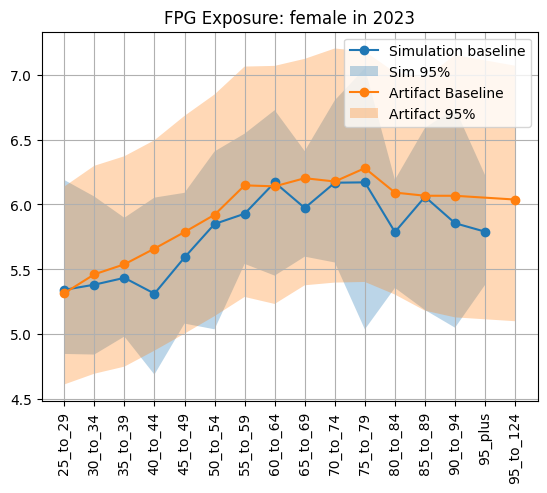

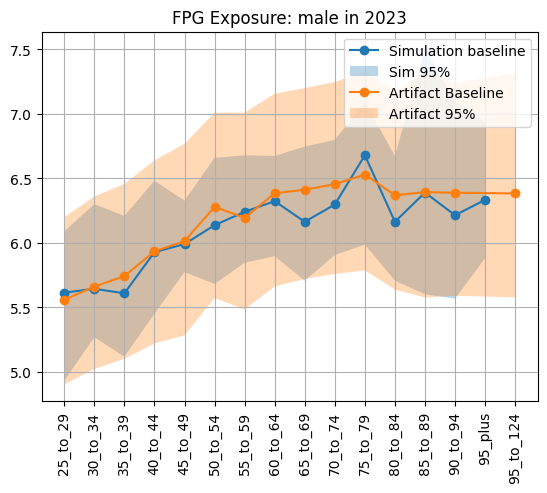

In [37]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

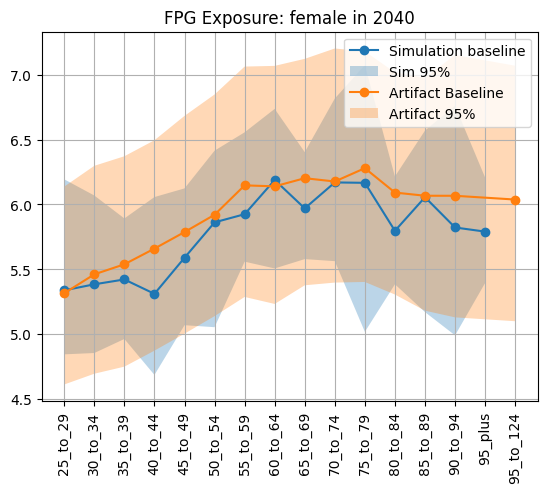

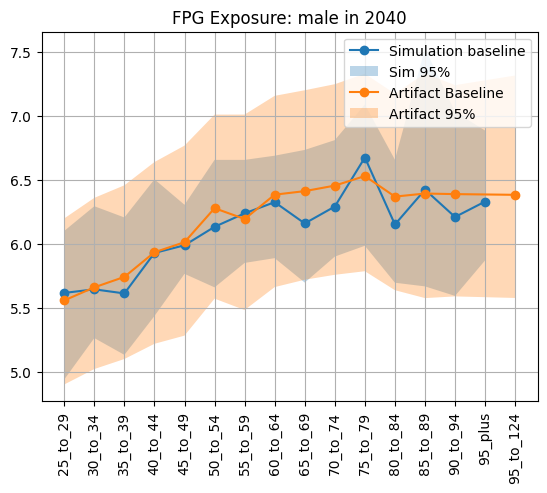

In [38]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad